# 1. Business Problem
The ojective of this project is to predict whether a client of the company **Home Credit** will default a loan. For that I will use the dataset([available here](https://www.kaggle.com/competitions/home-credit-default-risk/data)) provided for a kaggle competition. This challenge is crucial for Home Credit, a financial institution aiming to provide loans to clients with limited credit history or access to traditional banking services. By leveraging various data sources, including a client's financial history, previous applications, and bureau data, the goal is to develop predictive models that assist in assessing creditworthiness and mitigating default risk. Ultimately, the success of this project directly impacts Home Credit's ability to make informed lending decisions, manage risk effectively, and improve financial inclusion for underserved populations.

**The project objectives include:**

1. Developing predictive models to assess the creditworthiness of clients.
2. Mitigating default risk by accurately identifying clients likely to default on loans.
3. Improving Home Credit's ability to make informed lending decisions.

**The benefits of the project include:**

1. Enhancing Home Credit's risk management practices by leveraging predictive analytics.
2. Improving financial inclusion by extending loans to underserved populations with limited credit history.
3. Enhancing the overall efficiency and effectiveness of Home Credit's lending operations.

**Approach:**

The project employs the ROC-AUC metric for model evaluation, ensuring robust performance assessment across various thresholds. Predicted probabilities are utilized to prioritize efforts and resources on clients with the highest risk of default. This probability ordering approach enables Home Credit to make informed lending decisions while effectively managing default risk.

----

# 2. Understanding the data

For this project we have multiple tables and columns, let's first try to understand the tables and columns.

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
from src.utils.plots import plot_numerical_distribution, plot_boxplots,plot_categorical_variables
from src.utils.utils import print_description, quantify_chi2_target, get_column_types
from src.feature_engineering.feature_engineering import aggregate_categorical

import warnings
warnings.filterwarnings('ignore')

pos_color = '#f54900'
neg_color = '#0a664f'

In [53]:
df_description = pd.read_csv('../data/tables/HomeCredit_columns_description.csv')
df_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


In [4]:
df_description['Table'].unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [99]:
df_description.Special.unique()

array([nan, 'normalized ', 'time only relative to the application',
       'rounded', 'normalized', 'hashed', 'recoded', 'grouped'],
      dtype=object)


---

### Dataset Overview

1. **application_{train|test}.csv**
   - Description: This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET). Static data for all applications. One row represents one loan in our data sample.

2. **bureau.csv**
   - Description: All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as the number of credits the client had in Credit Bureau before the application date.

3. **bureau_balance.csv**
   - Description: Monthly balances of previous credits in Credit Bureau. This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e., the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

4. **POS_CASH_balance.csv**
   - Description: Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e., the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

5. **credit_card_balance.csv**
   - Description: Monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e., the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

6. **previous_application.csv**
   - Description: All previous applications for Home Credit loans of clients who have loans in our sample. There is one row for each previous application related to loans in our data sample.

7. **installments_payments.csv**
   - Description: Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. There is a) one row for every payment that was made plus b) one row each for missed payment. One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

8. **HomeCredit_columns_description.csv**
   - Description: This file contains descriptions for the columns in the various data files.

---

![Alt text](../images/erd.png)


In [54]:
df_description[df_description['Table'] == 'bureau.csv'].head()

,index,Table,Row,Description,Special
122,125,bureau.csv,SK_ID_CURR,ID of loan in our sample - one loan in our sam...,hashed
123,126,bureau.csv,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit re...,hashed
124,127,bureau.csv,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,NaN
125,128,bureau.csv,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,recoded
126,129,bureau.csv,DAYS_CREDIT,How many days before current application did c...,time only relative to the application


This table 'HomeCredit_columns_description.csv' describes the columns of all tables. We may use it to understand better the columns and maybe to create new features

# 3. Exploratory Data Analysis

To kick off the analysis, I'll focus on exploring the features within the 'application_train' table. This initial step allows us to gain insights into the dataset's structure, distribution, and relationships before delving into the creation of new features through the exploration of other tables.

In [29]:
df_application_train = pd.read_csv('../data/tables/application_train.csv')
print(df_application_train.shape)
df_application_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
missing_values = df_application_train.isnull().sum()
missing_values[missing_values>0]

AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
OWN_CAR_AGE                   202929
OCCUPATION_TYPE                96391
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 67, dtype: int64

In [19]:
col_type_counts = df_application_train.dtypes.value_counts()
print(col_type_counts)

float64    65
int64      41
object     16
Name: count, dtype: int64


In [56]:
numerical_columns, categorical_columns = get_column_types(df_application_train)

Numerical columns: 66 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI'

In [11]:
df_application_train[numerical_columns].std().sort_values()

REGION_POPULATION_RELATIVE          0.013831
NONLIVINGAPARTMENTS_MODE            0.046276
NONLIVINGAPARTMENTS_MEDI            0.047415
NONLIVINGAPARTMENTS_AVG             0.047732
YEARS_BEGINEXPLUATATION_AVG         0.059223
                                   ...      
AMT_ANNUITY                     14493.737315
DAYS_EMPLOYED                  141275.766519
AMT_INCOME_TOTAL               237123.146279
AMT_GOODS_PRICE                369446.460540
AMT_CREDIT                     402490.776996
Length: 69, dtype: float64

In [12]:
for feature in categorical_columns:
    print(feature)
    print('-'*40)
    print(f'There are {df_application_train[feature].nunique()} unique values. They are: ')
    print(df_application_train[feature].value_counts(normalize=True))
    print()

NAME_CONTRACT_TYPE
----------------------------------------
There are 2 unique values. They are: 
NAME_CONTRACT_TYPE
Cash loans         0.904787
Revolving loans    0.095213
Name: proportion, dtype: float64

CODE_GENDER
----------------------------------------
There are 3 unique values. They are: 
CODE_GENDER
F      0.658344
M      0.341643
XNA    0.000013
Name: proportion, dtype: float64

FLAG_OWN_CAR
----------------------------------------
There are 2 unique values. They are: 
FLAG_OWN_CAR
N    0.659892
Y    0.340108
Name: proportion, dtype: float64

FLAG_OWN_REALTY
----------------------------------------
There are 2 unique values. They are: 
FLAG_OWN_REALTY
Y    0.693673
N    0.306327
Name: proportion, dtype: float64

NAME_TYPE_SUITE
----------------------------------------
There are 7 unique values. They are: 
NAME_TYPE_SUITE
Unaccompanied      0.811596
Family             0.131112
Spouse, partner    0.037130
Children           0.010669
Other_B            0.005780
Other_A          

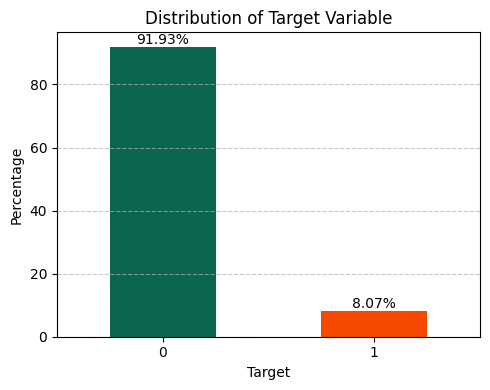

In [13]:
target_distribution = df_application_train['TARGET'].value_counts(normalize=True) * 100

plt.figure(figsize=(5, 4))
ax = target_distribution.plot(kind='bar', color=[neg_color, pos_color])
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(target_distribution):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

### Insights

From the initial exploration of the dataset, several key insights emerge:
- **Missing Values**: The dataset contains 67 columns with missing values, indicating the need for data imputation or handling missing values during preprocessing.
- **Data Types**: Among the columns, approximately 69 are numeric, while 51 are categorical, providing a varied mix of data types for analysis.
- **Target Distribution**: The target variable exhibits class imbalance, with the positive class representing about 8% of the total observations. This imbalance may require special attention during model training to prevent biased predictions.

---


### Feature Exploration

We will explore the dataset's features to identify the most influential ones using correlation analysis for numerical features and chi-squared analysis for categorical features. Subsequently, we will visualize these features in relation to the target variable.

Starting with numerical features:

In [354]:
corr_matrix = df_application_train[numerical_columns+['TARGET']].corr(numeric_only=True)
corr_matrix_abs = corr_matrix['TARGET'].abs().sort_values(ascending=False)
corr_matrix_abs

TARGET                        1.000000
EXT_SOURCE_3                  0.178919
EXT_SOURCE_2                  0.160472
EXT_SOURCE_1                  0.155317
DAYS_BIRTH                    0.078239
                                ...   
NONLIVINGAPARTMENTS_MEDI      0.002757
AMT_REQ_CREDIT_BUREAU_DAY     0.002704
AMT_REQ_CREDIT_BUREAU_QRT     0.002022
NONLIVINGAPARTMENTS_MODE      0.001557
AMT_REQ_CREDIT_BUREAU_WEEK    0.000788
Name: TARGET, Length: 70, dtype: float64

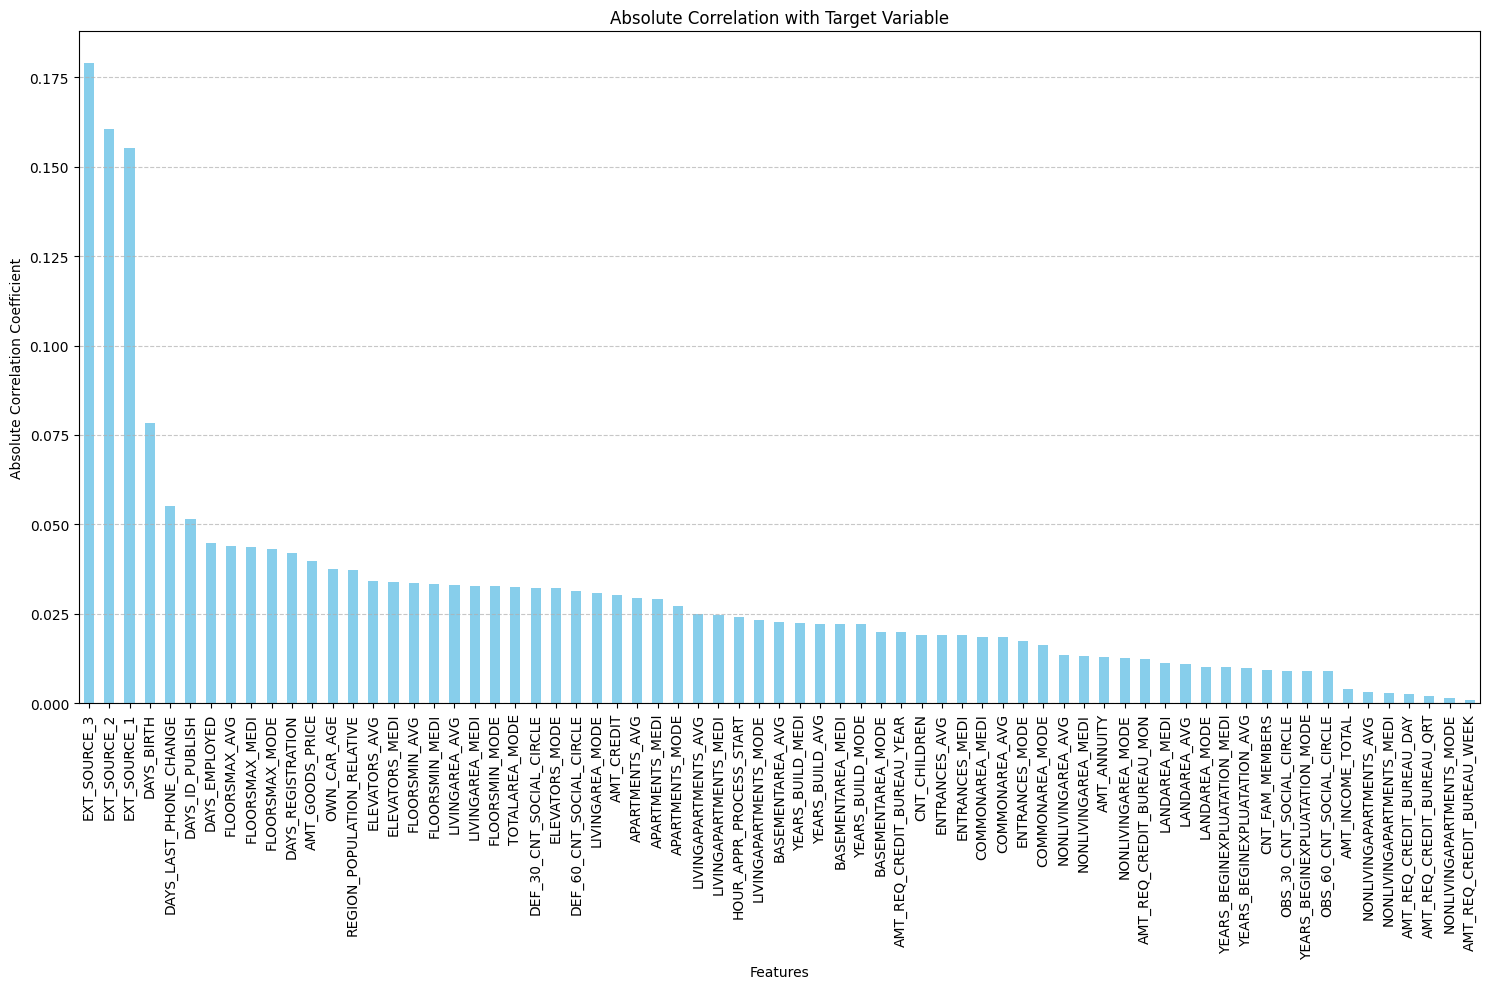

In [161]:
plt.figure(figsize=(15, 10))
corr_matrix_abs[1:].plot(kind='bar', color='skyblue')
plt.title('Absolute Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

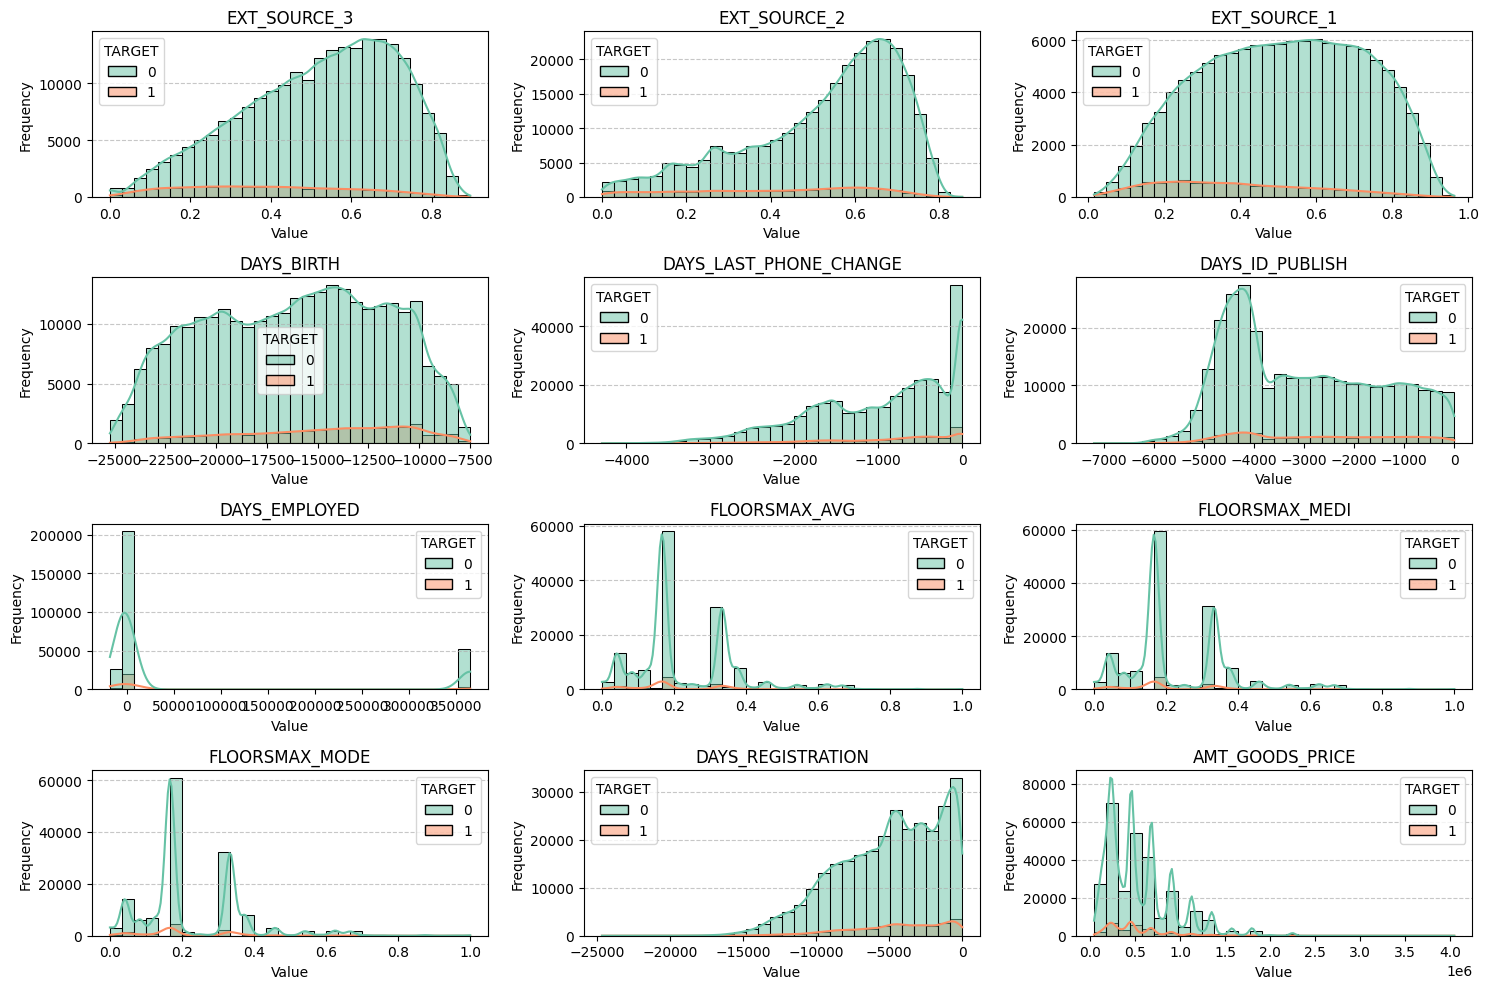

In [11]:
plot_numerical_distribution(
    df_application_train, 
    corr_matrix_abs.index[1:13], 
    target_column='TARGET', 
    kde=True, 
    color=[pos_color, neg_color])

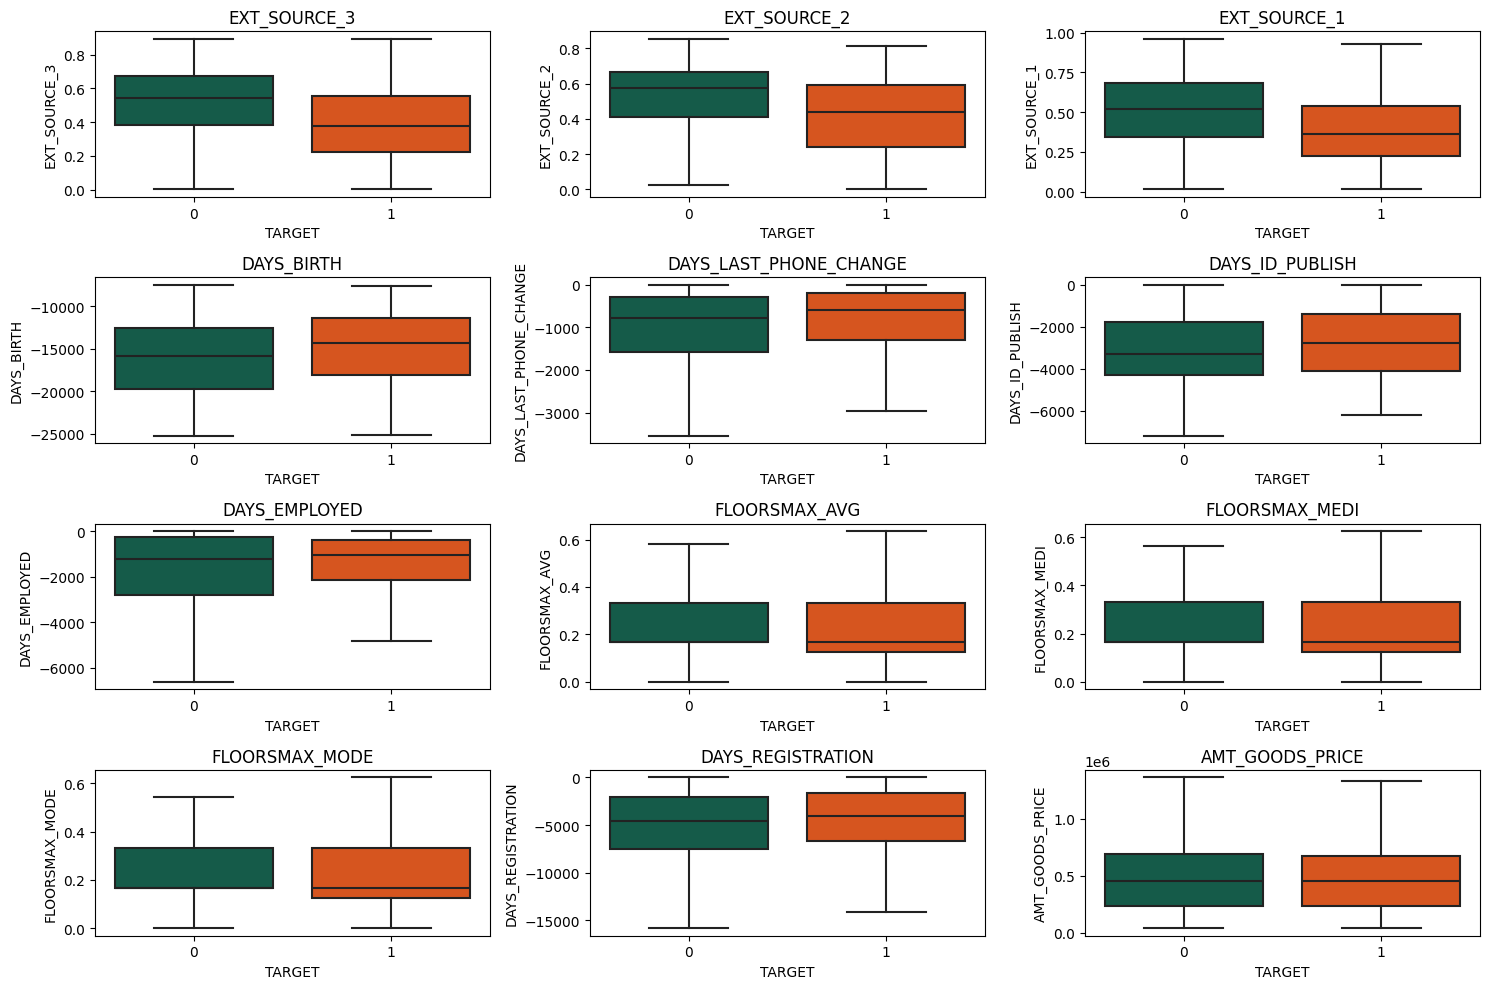

In [369]:
plot_boxplots(df_application_train,  corr_matrix_abs.index[1:13], 'TARGET' , pos_color, neg_color)

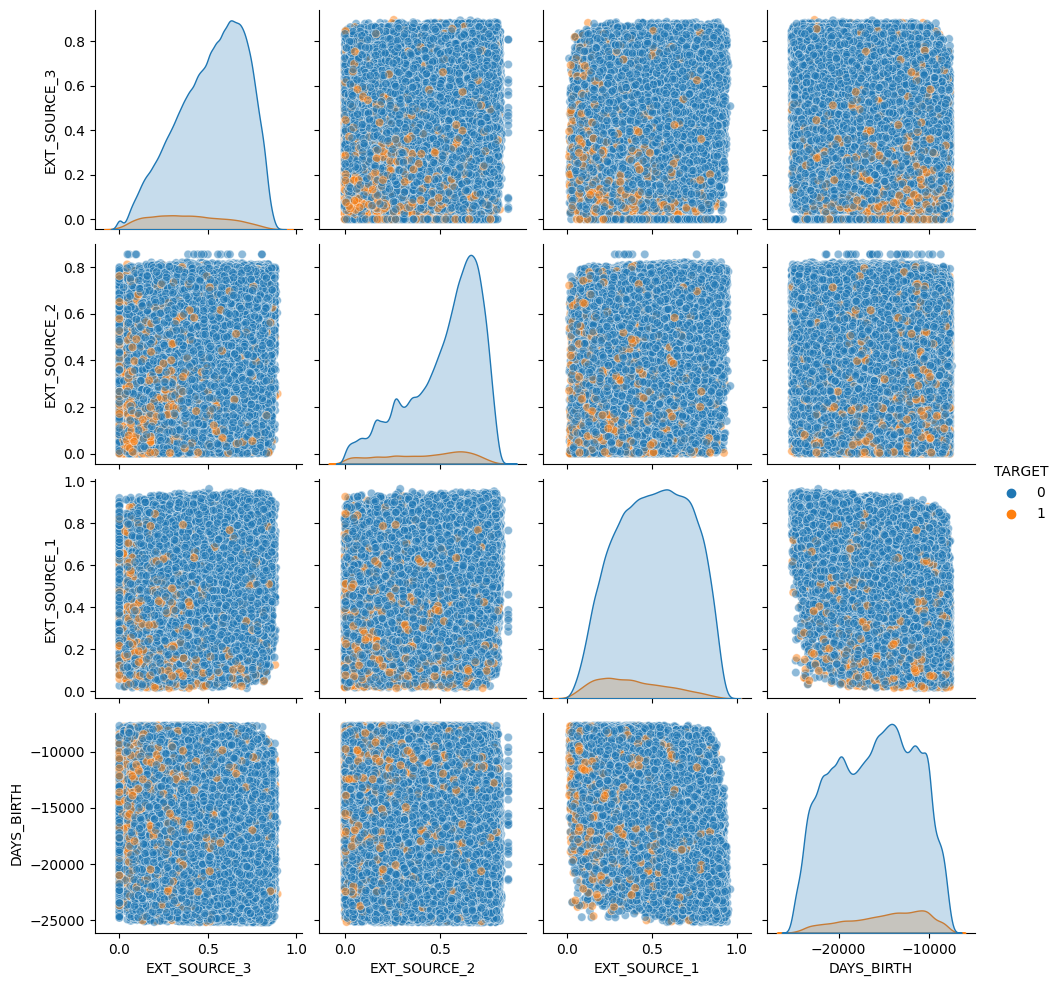

In [185]:
sns.pairplot(df_application_train[corr_matrix_abs.index[:5]], hue="TARGET", plot_kws={'alpha':0.5})
plt.show()

In [5]:

relationship_results = quantify_chi2_target(df_application_train, categorical_columns, 'TARGET').sort_values('Chi-square', ascending=False)
sorted_cat_features = relationship_results['Feature'].to_list()

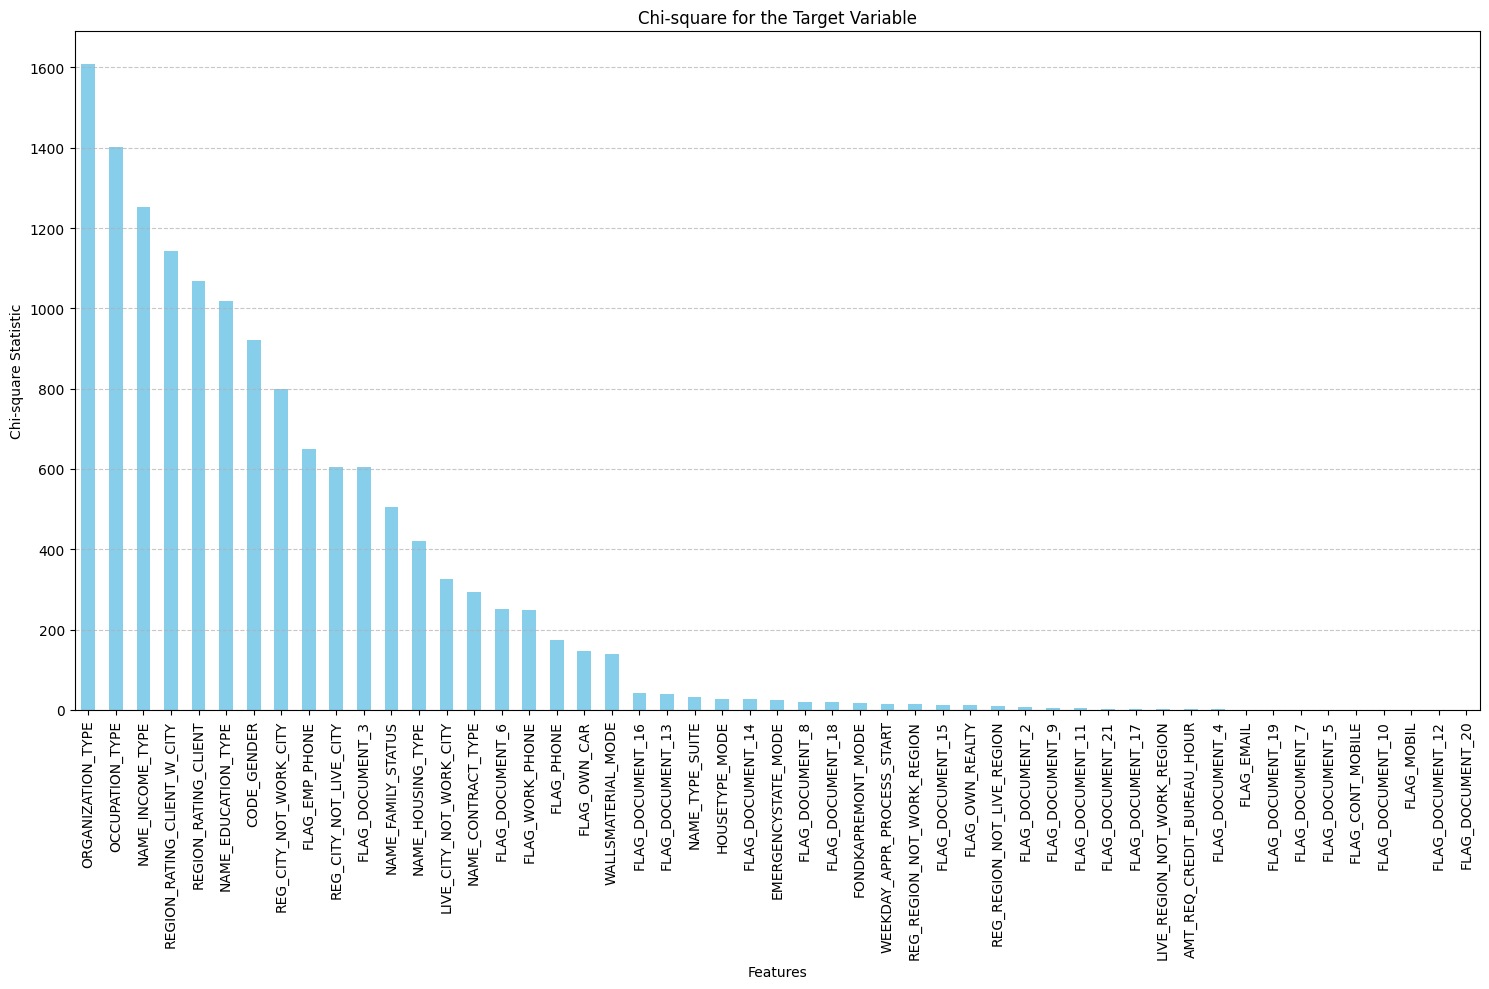

In [6]:
fig = plt.figure(figsize=(15, 10))
relationship_results['Chi-square'].plot(kind='bar', color='skyblue')
plt.title('Chi-square for the Target Variable')
plt.xlabel('Features')
plt.ylabel('Chi-square Statistic')
plt.xticks(ticks=range(len(sorted_cat_features)), labels=sorted_cat_features, rotation=90)  # Set tick labels using 'important'
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


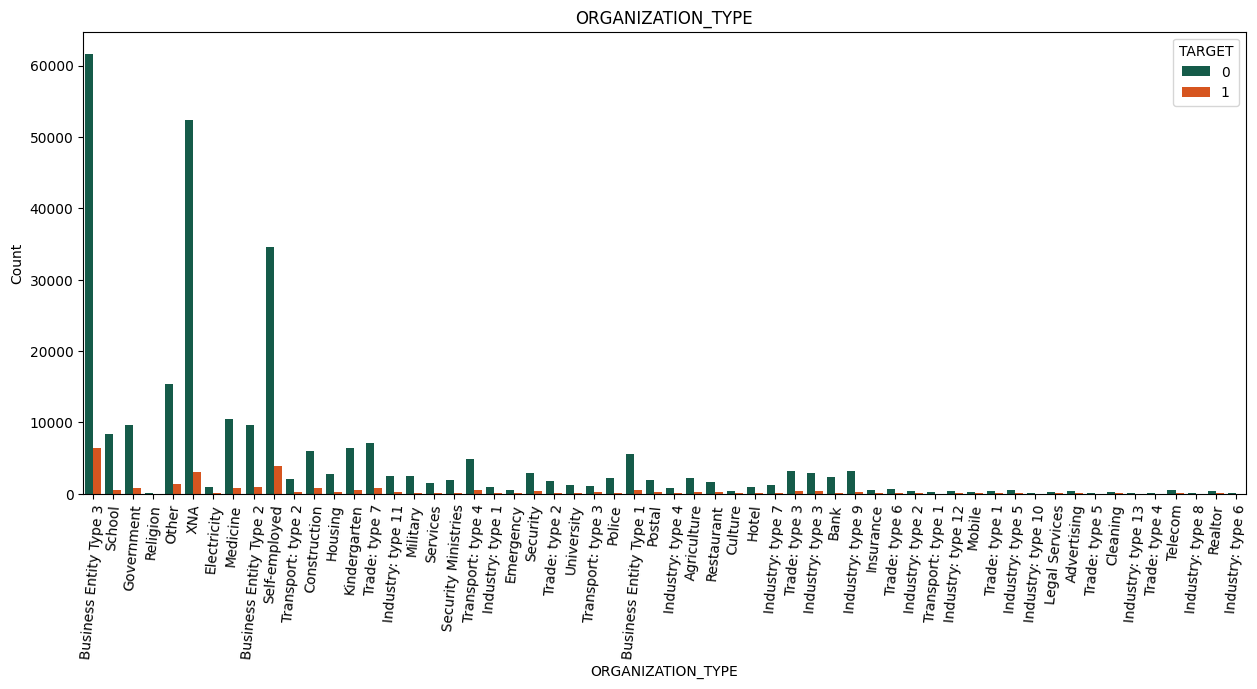

In [7]:
plt.figure(figsize=(15, 6))
sns.countplot(x=sorted_cat_features[0], hue='TARGET', data=df_application_train, palette=[neg_color, pos_color])
plt.title(sorted_cat_features[0])
plt.xlabel(sorted_cat_features[0])
plt.ylabel('Count')
plt.legend(title='TARGET')
plt.xticks(rotation=85)
plt.show()

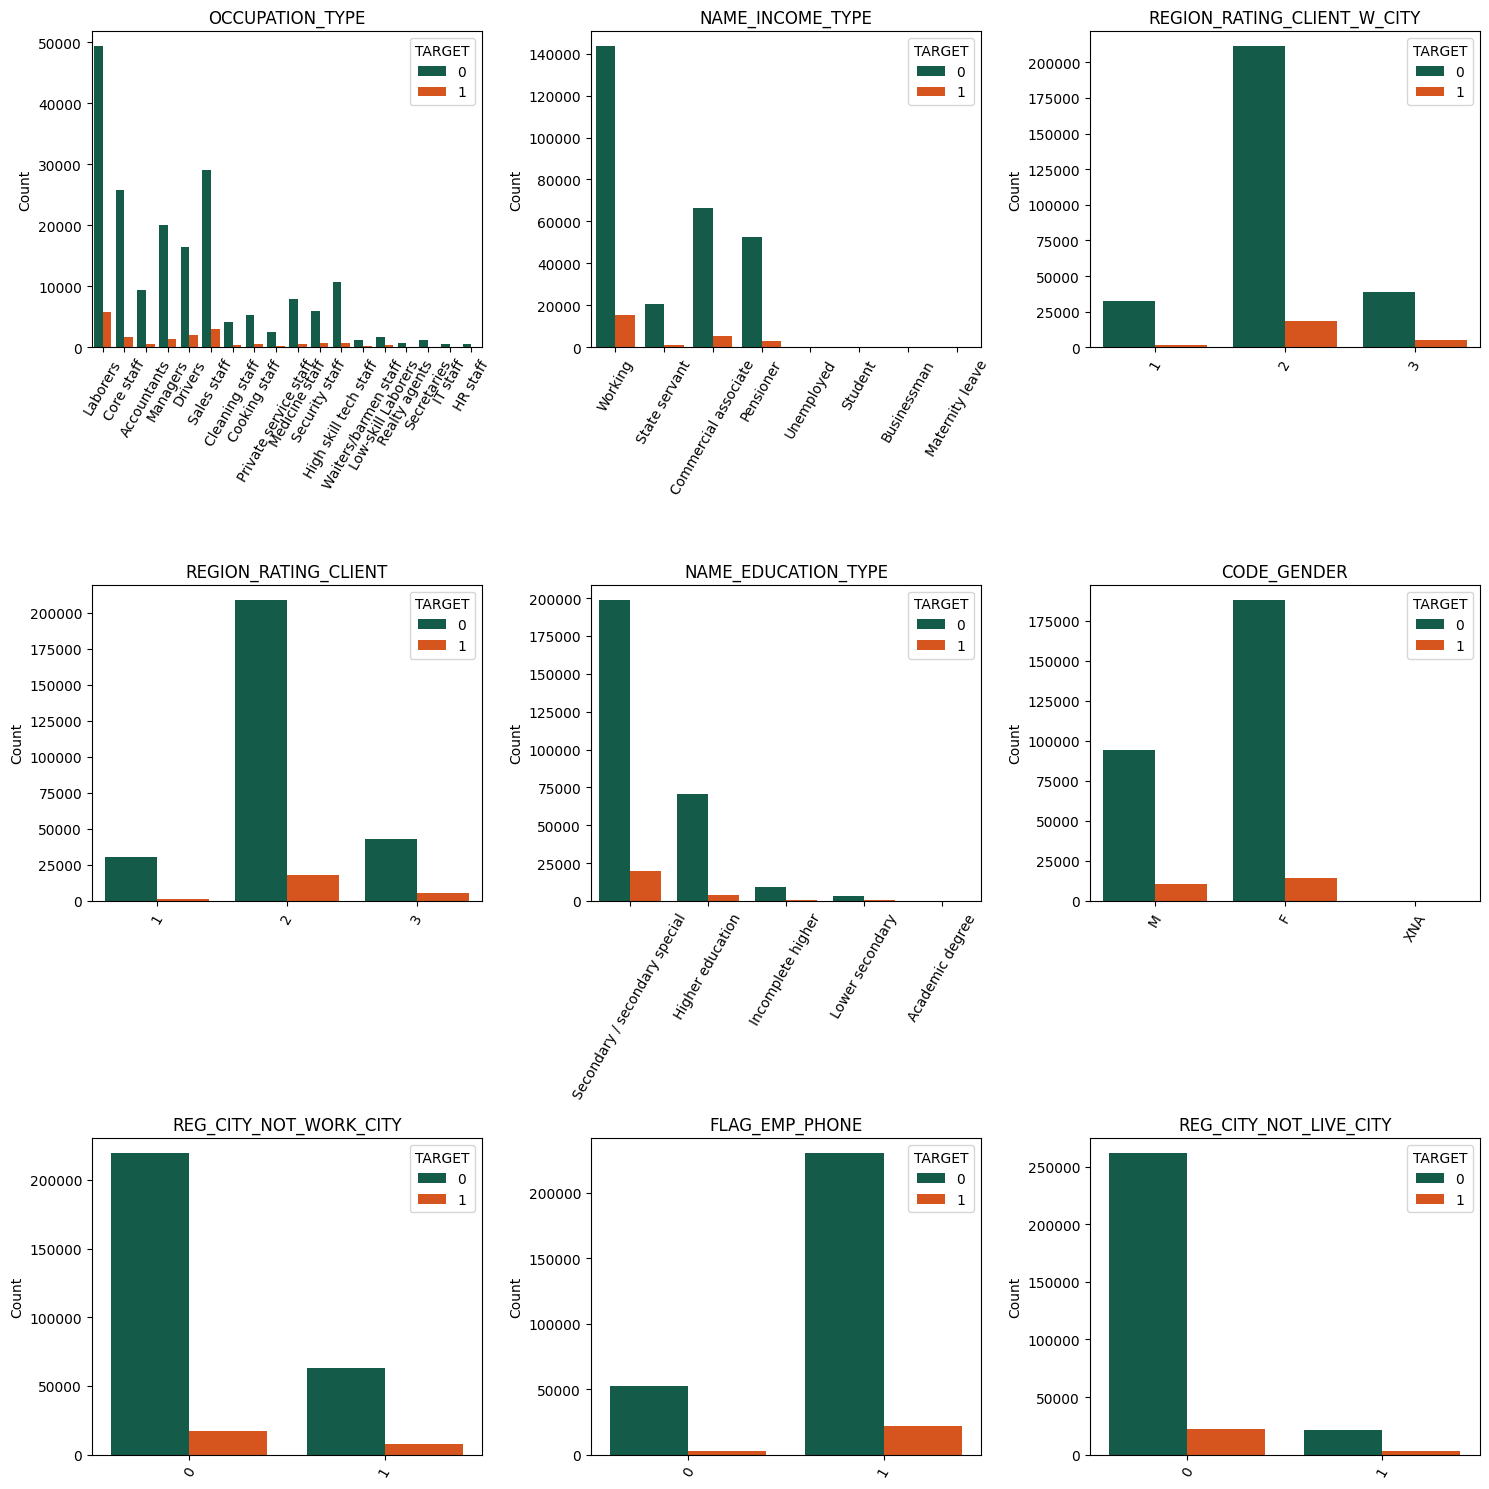

In [9]:
plot_categorical_variables(df_application_train, sorted_cat_features[1:10], 'TARGET', color = [neg_color, pos_color])


### Conclusions

While certain columns do exhibit some association with the target variable, the observed relationships are not particularly strong. Therefore, the next step would be to explore the creation of new features to potentially enhance model performance.

---

# 4. Feature Engeneering

### 4.1 Credit Bureau Features
I will start start by analysing tha tables 'bureau' and 'bureau_balance' they are linked by SK_ID_BUREAU. Those tables have information about previous credits provided by other financial institutions that were reported to Credit Bureau.
Let's take a look at the description of the columns:

#### Description bureau

- **SK_ID_CURR**: ID of loan in our sample - one loan in our sample can have 0, 1, 2, or more related previous credits in the credit bureau
- **SK_BUREAU_ID**: Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)
- **CREDIT_ACTIVE**: Status of the Credit Bureau (CB) reported credits
- **CREDIT_CURRENCY**: Recoded currency of the Credit Bureau credit
- **DAYS_CREDIT**: How many days before the current application did the client apply for Credit Bureau credit
- **CREDIT_DAY_OVERDUE**: Number of days past due on CB credit at the time of application for related loan in our sample
- **DAYS_CREDIT_ENDDATE**: Remaining duration of CB credit (in days) at the time of application in Home Credit
- **DAYS_ENDDATE_FACT**: Days since CB credit ended at the time of application in Home Credit (only for closed credit)
- **AMT_CREDIT_MAX_OVERDUE**: Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
- **CNT_CREDIT_PROLONG**: How many times was the Credit Bureau credit prolonged
- **AMT_CREDIT_SUM**: Current credit amount for the Credit Bureau credit
- **AMT_CREDIT_SUM_DEBT**: Current debt on Credit Bureau credit
- **AMT_CREDIT_SUM_LIMIT**: Current credit limit of credit card reported in Credit Bureau
- **AMT_CREDIT_SUM_OVERDUE**: Current amount overdue on Credit Bureau credit
- **CREDIT_TYPE**: Type of Credit Bureau credit (Car, cash, ...)
- **DAYS_CREDIT_UPDATE**: How many days before loan application did the last information about the Credit Bureau credit come
- **AMT_ANNUITY**: Annuity of the Credit Bureau credit

#### Description bureau_balance:

- **SK_BUREAU_ID**: Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table
- **MONTHS_BALANCE**: Month of balance relative to application date (-1 means the freshest balance date)
- **STATUS**: Status of Credit Bureau loan during the month (active, closed, DPD0-30, [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during the month between 1-30, 2 means DPD 31-60, 5 means DPD 120+ or sold or written off])

In [2]:
df_bureau = pd.read_csv('../data/tables/bureau.csv')
df_bureau_balance =pd.read_csv('../data/tables/bureau_balance.csv')

In [3]:
print(df_bureau_balance.shape)
print(df_bureau_balance.nunique())
df_bureau_balance.head()

(27299925, 3)
SK_ID_BUREAU      817395
MONTHS_BALANCE        97
STATUS                 8
dtype: int64


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [4]:
print(df_bureau.shape)
print(df_bureau.nunique())
df_bureau.head()

(1716428, 17)
SK_ID_CURR                 305811
SK_ID_BUREAU              1716428
CREDIT_ACTIVE                   4
CREDIT_CURRENCY                 4
DAYS_CREDIT                  2923
CREDIT_DAY_OVERDUE            942
DAYS_CREDIT_ENDDATE         14096
DAYS_ENDDATE_FACT            2917
AMT_CREDIT_MAX_OVERDUE      68251
CNT_CREDIT_PROLONG             10
AMT_CREDIT_SUM             236708
AMT_CREDIT_SUM_DEBT        226537
AMT_CREDIT_SUM_LIMIT        51726
AMT_CREDIT_SUM_OVERDUE       1616
CREDIT_TYPE                    15
DAYS_CREDIT_UPDATE           2982
AMT_ANNUITY                 40321
dtype: int64


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


We can observe that in the 'bureau_balance' table, there is information available for fewer than half of the transactions in the 'bureau' table (817,395 out of 1,716,428 SK_ID_BUREAU). This discrepancy can be attributed to the fact that monthly balances are not reported for some credits, resulting in missing data in the balance table. However, we can still create a feature for those transactions, even if most of them will have missing values.

For every **SK_ID_BUREAU**, the average of the Days Past Due (DPD) that is reported in the STATUS column can be calculated. In this case, it will be a weighted average, where STATUS 5 carries the most weight. This approach makes sense since STATUS 5 represents the most serious scenario (DPD 120+ or the credit being sold or written off). STATUS 'Closed' (C) or 'Unknown' (X) will be considered as no Days Past Due (0), as follows:

In [5]:
df_bureau_balance['STATUS_NUM'] = df_bureau_balance['STATUS'].replace(['C', 'X'],0).astype(int)
df_avg_status = df_bureau_balance.groupby('SK_ID_BUREAU', as_index=False)['STATUS_NUM'].mean()\
    .rename(columns = {'STATUS_NUM':'AVG_STATUS'})

df_avg_status.head(10)

,SK_ID_BUREAU,AVG_STATUS
0,5001709,0.000000
1,5001710,0.000000
2,5001711,0.000000
3,5001712,0.000000
4,5001713,0.000000
5,5001714,0.000000
6,5001715,0.000000
7,5001716,0.000000
8,5001717,0.000000
9,5001718,0.051282


In [6]:
df_bureau2 = df_bureau.merge(df_avg_status, 'left', 'SK_ID_BUREAU')
df_bureau2.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,AVG_STATUS
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN


In [8]:
df_bureau2[ 'AVG_STATUS'].isna().sum()/df_bureau2.shape[0]

0.5488572780215657

#### 55% of CB credits lack any entry in the 'bureau' table.

Now, I'll proceed with the aggregations to generate the new features.

In [15]:
aggregations = {
    'CREDIT_DAY_OVERDUE': [
        ('MAX_CREDIT_DAYS_OVERDUE', 'max'),
        ('AVG_CREDIT_DAYS_OVERDUE', 'mean'),
        ('TOTAL_CREDIT_DAYS_OVERDUE', 'sum'),
        ('NUM_CREDITS_OVERDUE', lambda x: (x != 0).sum())
    ],
    'DAYS_CREDIT_ENDDATE': [('AVG_DAYS_CREDIT_ENDDATE', 'mean')],
    'DAYS_ENDDATE_FACT': [('DAYS_LAST_ACTIVE_CREDIT', 'max')],
    'AMT_CREDIT_MAX_OVERDUE': [('MAX_AMT_CREDIT_MAX_OVERDUE', 'max')],
    'CNT_CREDIT_PROLONG': [('AVG_CNT_CREDIT_PROLONG', 'mean')],
    'AMT_CREDIT_SUM': [('MAX_AMT_CREDIT_SUM', 'sum')],
    'AMT_CREDIT_SUM_DEBT': [('SUM_AMT_CREDIT_SUM_DEBT', 'sum')],
    'AMT_CREDIT_SUM_LIMIT': [('AVG_AMT_CREDIT_SUM_LIMIT', 'mean')],
    'AMT_CREDIT_SUM_OVERDUE': [('SUM_AMT_CREDIT_SUM_OVERDUE', 'sum')],
    'AMT_ANNUITY': [('AVG_AMT_ANNUITY', 'mean')],
    'AVG_STATUS': [('MAX_AVG_STATUS', 'mean')]
}

numerical_agg = df_bureau2.groupby('SK_ID_CURR').agg(aggregations)
numerical_agg.columns = [col[1] for col in numerical_agg.columns]
# numerical_agg.reset_index(inplace=True)
numerical_agg.head()

,MAX_CREDIT_DAYS_OVERDUE,AVG_CREDIT_DAYS_OVERDUE,TOTAL_CREDIT_DAYS_OVERDUE,NUM_CREDITS_OVERDUE,AVG_DAYS_CREDIT_ENDDATE,DAYS_LAST_ACTIVE_CREDIT,MAX_AMT_CREDIT_MAX_OVERDUE,AVG_CNT_CREDIT_PROLONG,MAX_AMT_CREDIT_SUM,SUM_AMT_CREDIT_SUM_DEBT,AVG_AMT_CREDIT_SUM_LIMIT,SUM_AMT_CREDIT_SUM_OVERDUE,AVG_AMT_ANNUITY,MAX_AVG_STATUS
SK_ID_CURR,,,,,,,,,,,,,,
100001,0,0.0,0,0,82.428571,-544.0,NaN,0.0,1453365.000,596686.5,0.00000,0.0,3545.357143,0.007519
100002,0,0.0,0,0,-349.000000,-36.0,5043.645,0.0,865055.565,245781.0,7997.14125,0.0,0.000000,0.255682
100003,0,0.0,0,0,-544.500000,-540.0,0.000,0.0,1017400.500,0.0,202500.00000,0.0,NaN,NaN
100004,0,0.0,0,0,-488.500000,-382.0,0.000,0.0,189037.800,0.0,0.00000,0.0,NaN,NaN
100005,0,0.0,0,0,439.333333,-123.0,0.000,0.0,657126.000,568408.5,0.00000,0.0,1420.500000,0.000000


In [11]:
_, categorical_columns = get_column_types(df_bureau2, 2)

Numerical columns: 15 ['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'AVG_STATUS']
Categorical columns: 3 ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']


In [19]:
categorical_agg = aggregate_categorical(df_bureau2,categorical_columns, 'SK_ID_CURR')
categorical_agg.head()

,CREDIT_ACTIVE_Active_COUNT,CREDIT_ACTIVE_Bad debt_COUNT,CREDIT_ACTIVE_Closed_COUNT,CREDIT_ACTIVE_Sold_COUNT,CREDIT_CURRENCY_currency 1_COUNT,CREDIT_CURRENCY_currency 2_COUNT,CREDIT_CURRENCY_currency 3_COUNT,CREDIT_CURRENCY_currency 4_COUNT,CREDIT_TYPE_Another type of loan_COUNT,CREDIT_TYPE_Car loan_COUNT,...,CREDIT_TYPE_Interbank credit_COUNT,CREDIT_TYPE_Loan for business development_COUNT,CREDIT_TYPE_Loan for purchase of shares (margin lending)_COUNT,CREDIT_TYPE_Loan for the purchase of equipment_COUNT,CREDIT_TYPE_Loan for working capital replenishment_COUNT,CREDIT_TYPE_Microloan_COUNT,CREDIT_TYPE_Mobile operator loan_COUNT,CREDIT_TYPE_Mortgage_COUNT,CREDIT_TYPE_Real estate loan_COUNT,CREDIT_TYPE_Unknown type of loan_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0,4,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100002,2,0,6,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100003,1,0,3,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100004,0,0,2,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100005,2,0,1,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
pivot_table = df_bureau2.pivot_table(index='SK_ID_CURR', 
                                               columns='CREDIT_ACTIVE', 
                                               values='DAYS_CREDIT', 
                                               aggfunc='max')
pivot_table
DAYS_CREDIT_feature = pivot_table[['Active']]\
    .rename(columns={'Active': 'DAYS_SINCE_LAST_ACTIVE_CREDIT_APPLICATION'})\
    .rename_axis(None, axis=1) #remove index name
DAYS_CREDIT_feature.head()

,DAYS_SINCE_LAST_ACTIVE_CREDIT_APPLICATION
SK_ID_CURR,
100001,-49.0
100002,-103.0
100003,-606.0
100004,NaN
100005,-62.0


In [22]:
df_buraeu_features = pd.concat([numerical_agg, categorical_agg, DAYS_CREDIT_feature], axis = 1).reset_index()

print(df_buraeu_features.shape)
df_buraeu_features.head()

(305811, 39)


,SK_ID_CURR,MAX_CREDIT_DAYS_OVERDUE,AVG_CREDIT_DAYS_OVERDUE,TOTAL_CREDIT_DAYS_OVERDUE,NUM_CREDITS_OVERDUE,AVG_DAYS_CREDIT_ENDDATE,DAYS_LAST_ACTIVE_CREDIT,MAX_AMT_CREDIT_MAX_OVERDUE,AVG_CNT_CREDIT_PROLONG,MAX_AMT_CREDIT_SUM,...,CREDIT_TYPE_Loan for business development_COUNT,CREDIT_TYPE_Loan for purchase of shares (margin lending)_COUNT,CREDIT_TYPE_Loan for the purchase of equipment_COUNT,CREDIT_TYPE_Loan for working capital replenishment_COUNT,CREDIT_TYPE_Microloan_COUNT,CREDIT_TYPE_Mobile operator loan_COUNT,CREDIT_TYPE_Mortgage_COUNT,CREDIT_TYPE_Real estate loan_COUNT,CREDIT_TYPE_Unknown type of loan_COUNT,DAYS_SINCE_LAST_ACTIVE_CREDIT_APPLICATION
0,100001,0,0.0,0,0,82.428571,-544.0,NaN,0.0,1453365.000,...,0,0,0,0,0,0,0,0,0,-49.0
1,100002,0,0.0,0,0,-349.000000,-36.0,5043.645,0.0,865055.565,...,0,0,0,0,0,0,0,0,0,-103.0
2,100003,0,0.0,0,0,-544.500000,-540.0,0.000,0.0,1017400.500,...,0,0,0,0,0,0,0,0,0,-606.0
3,100004,0,0.0,0,0,-488.500000,-382.0,0.000,0.0,189037.800,...,0,0,0,0,0,0,0,0,0,NaN
4,100005,0,0.0,0,0,439.333333,-123.0,0.000,0.0,657126.000,...,0,0,0,0,0,0,0,0,0,-62.0


In [43]:
new_features = list(df_buraeu_features.columns[1:])
len(new_features)

38

In [33]:
df_train = df_application_train.merge(df_buraeu_features, how='left')
print(df_train.shape)
df_train.head()

(307511, 160)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Loan for business development_COUNT,CREDIT_TYPE_Loan for purchase of shares (margin lending)_COUNT,CREDIT_TYPE_Loan for the purchase of equipment_COUNT,CREDIT_TYPE_Loan for working capital replenishment_COUNT,CREDIT_TYPE_Microloan_COUNT,CREDIT_TYPE_Mobile operator loan_COUNT,CREDIT_TYPE_Mortgage_COUNT,CREDIT_TYPE_Real estate loan_COUNT,CREDIT_TYPE_Unknown type of loan_COUNT,DAYS_SINCE_LAST_ACTIVE_CREDIT_APPLICATION
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-103.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-606.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Now, let's visualize the new features to observe their relationship with the target variable.

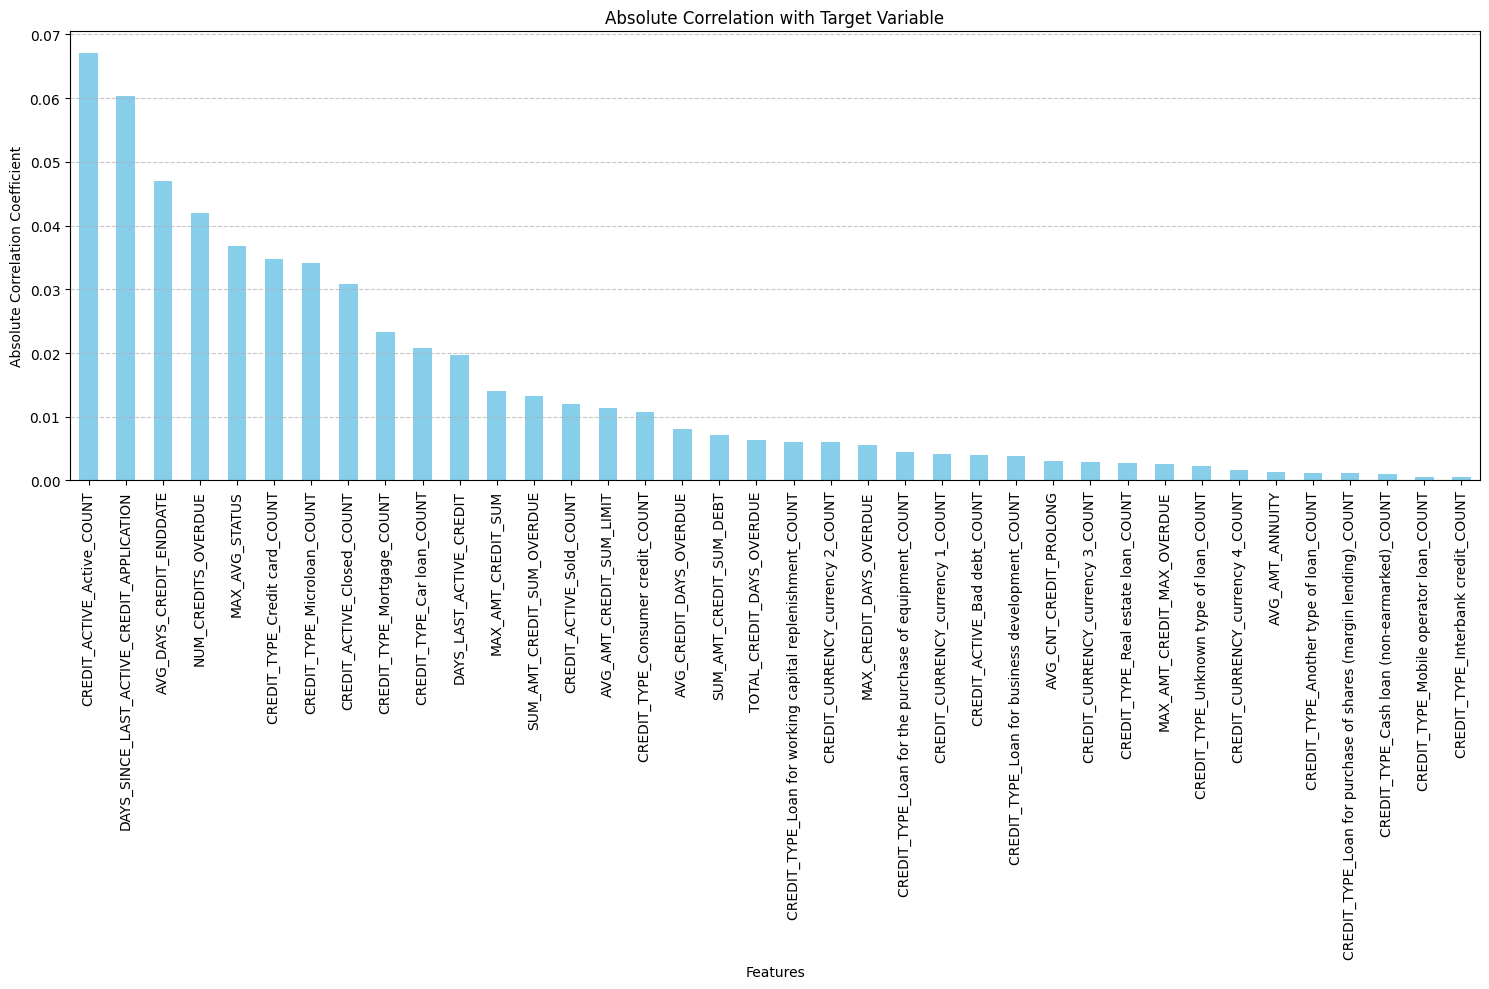

In [45]:
corr_matrix = df_train[new_features+['TARGET']].corr(numeric_only=True)
corr_matrix_abs = corr_matrix['TARGET'].abs().sort_values(ascending=False)
corr_matrix_abs

plt.figure(figsize=(15, 10))
corr_matrix_abs[1:].plot(kind='bar', color='skyblue')
plt.title('Absolute Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

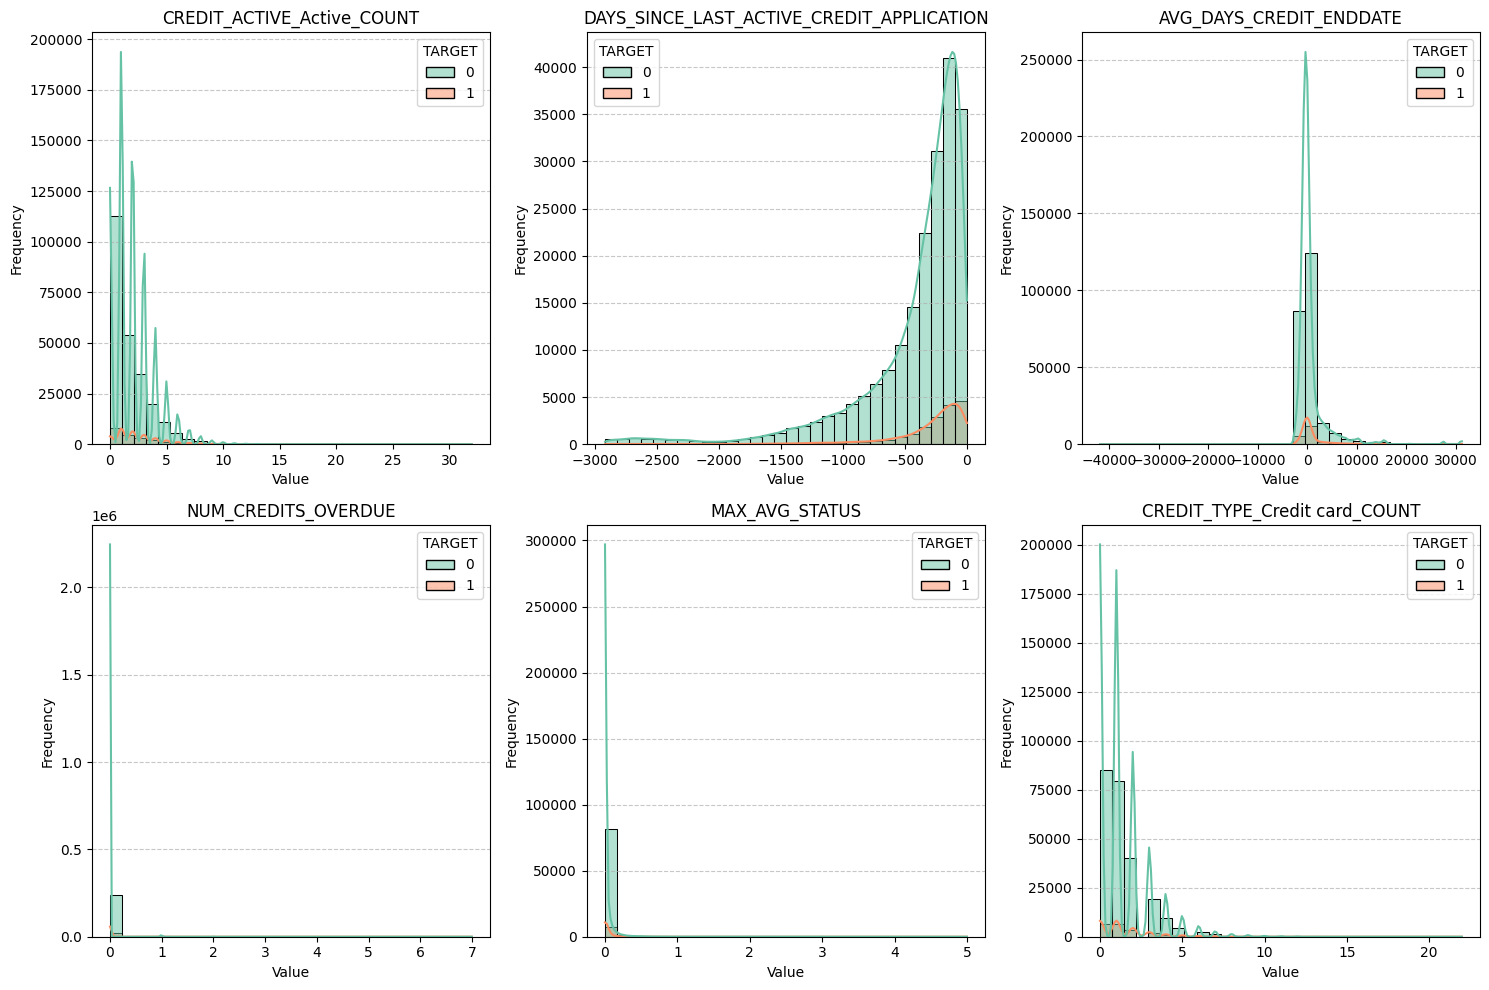

In [46]:

plot_numerical_distribution(df_train, 
                            corr_matrix_abs.index[1:7], 
                            'TARGET', 
                            kde=True, 
                            color=[pos_color, neg_color])

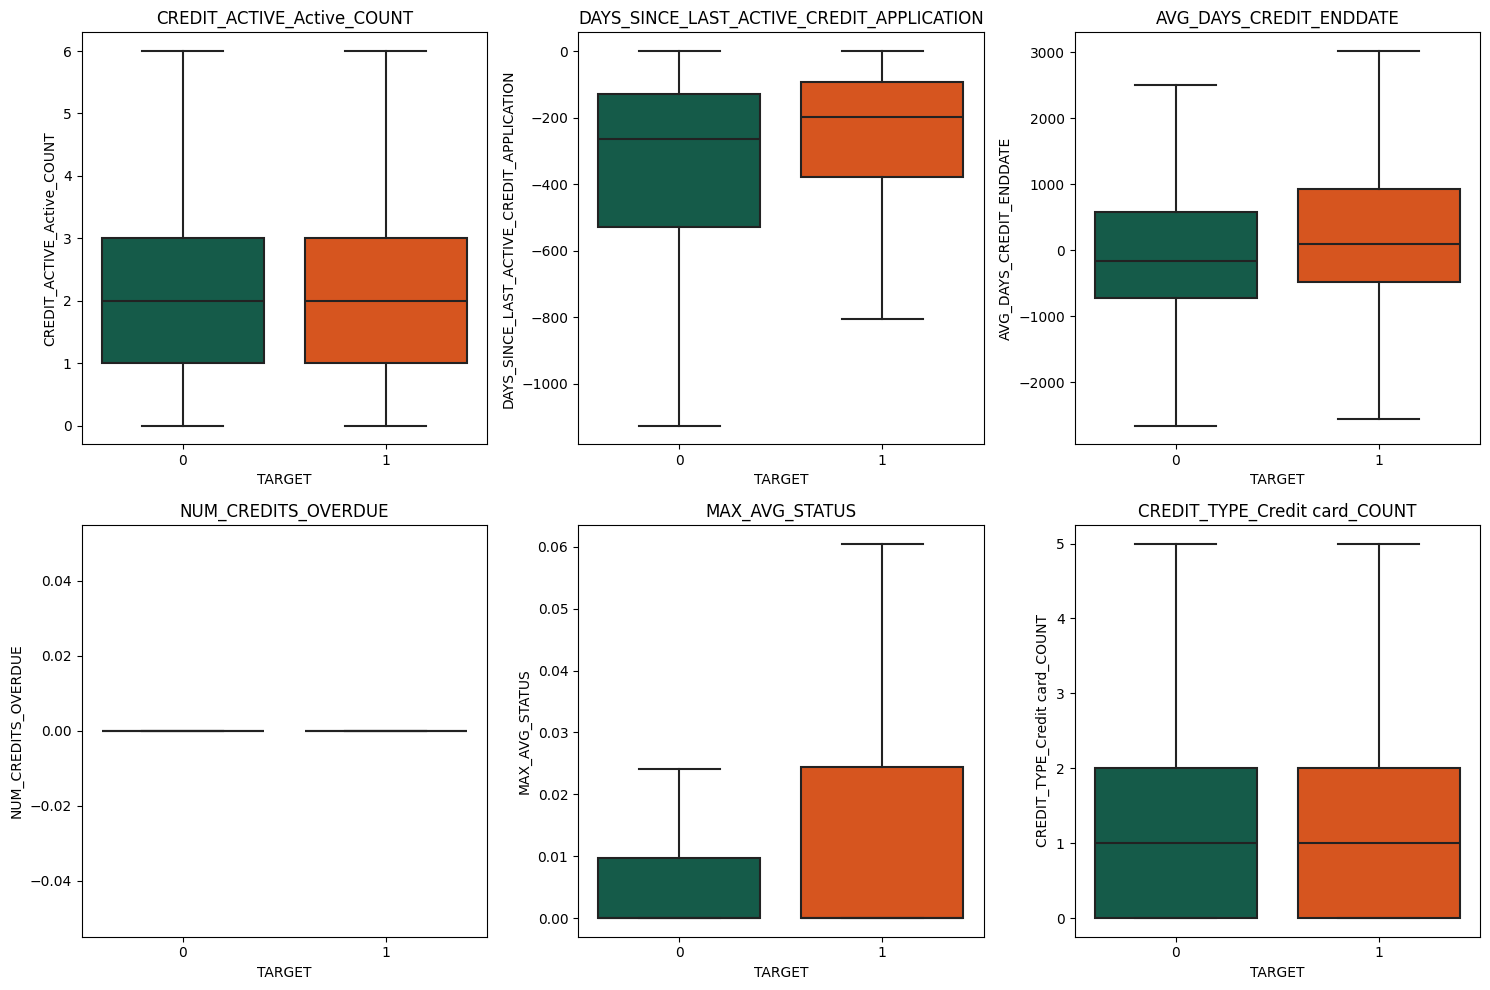

In [47]:
plot_boxplots(df_train, corr_matrix_abs.index[1:7], 'TARGET', pos_color, neg_color)

### Now let's save the new features and start building the model!

In [48]:
df_buraeu_features.to_csv('../data/tables/bureau_features.csv', index=False)

### 4.2 Home Credit Features

Now, in order to improve our model, let's make new features using the remaining tables.

### Description previous_application

- **SK_ID_PREV**: ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0, 1, 2, or more previous loan applications in Home Credit; previous application could, but not necessarily have to lead to credit)
- **SK_ID_CURR**: ID of loan in our sample
- **NAME_CONTRACT_TYPE**: Contract product type (Cash loan, consumer loan [POS], ...) of the previous application
- **AMT_ANNUITY**: Annuity of previous application
- **AMT_APPLICATION**: For how much credit did client ask on the previous application
- **AMT_CREDIT**: Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received a different amount - AMT_CREDIT
- **AMT_DOWN_PAYMENT**: Down payment on the previous application
- **AMT_GOODS_PRICE**: Goods price of good that client asked for (if applicable) on the previous application
- **WEEKDAY_APPR_PROCESS_START**: On which day of the week did the client apply for the previous application
- **HOUR_APPR_PROCESS_START**: Approximately at what day hour did the client apply for the previous application
- **FLAG_LAST_APPL_PER_CONTRACT**: Flag if it was the last application for the previous contract. Sometimes by mistake of the client or our clerk there could be more applications for one single contract
- **NFLAG_LAST_APPL_IN_DAY**: Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be an error in our system that one application is in the database twice
- **NFLAG_MICRO_CASH**: Flag Microfinance loan
- **RATE_DOWN_PAYMENT**: Down payment rate normalized on the previous credit
- **RATE_INTEREST_PRIMARY**: Interest rate normalized on the previous credit
- **RATE_INTEREST_PRIVILEGED**: Interest rate normalized on the previous credit
- **NAME_CASH_LOAN_PURPOSE**: Purpose of the cash loan
- **NAME_CONTRACT_STATUS**: Contract status (approved, canceled, ...) of the previous application
- **DAYS_DECISION**: Relative to the current application when was the decision about the previous application made
- **NAME_PAYMENT_TYPE**: Payment method that client chose to pay for the previous application
- **CODE_REJECT_REASON**: Why was the previous application rejected
- **NAME_TYPE_SUITE**: Who accompanied the client when applying for the previous application
- **NAME_CLIENT_TYPE**: Was the client an old or new client when applying for the previous application
- **NAME_GOODS_CATEGORY**: What kind of goods did the client apply for in the previous application
- **NAME_PORTFOLIO**: Was the previous application for CASH, POS, CAR, ...
- **NAME_PRODUCT_TYPE**: Was the previous application x-sell or walk-in
- **CHANNEL_TYPE**: Through which channel we acquired the client on the previous application
- **SELLERPLACE_AREA**: Selling area of seller place of the previous application
- **NAME_SELLER_INDUSTRY**: The industry of the seller
- **CNT_PAYMENT**: Term of previous credit at application of the previous application
- **NAME_YIELD_GROUP**: Grouped interest rate into small medium and high of the previous application
- **PRODUCT_COMBINATION**: Detailed product combination of the previous application
- **DAYS_FIRST_DRAWING**: Relative to the application date of the current application when was the first disbursement of the previous application
- **DAYS_FIRST_DUE**: Relative to the application date of the current application when was the first due supposed to be of the previous application
- **DAYS_LAST_DUE_1ST_VERSION**: Relative to the application date of the current application when was the first due of the previous application
- **DAYS_LAST_DUE**: Relative to the application date of the current application when was the last due date of the previous application
- **DAYS_TERMINATION**: Relative to the application date of the current application when was the expected termination of the previous application
- **NFLAG_INSURED_ON_APPROVAL**: Did the client request insurance during the previous application

### Description POS_CASH_balance

- **SK_ID_PREV**: ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0, 1, 2, or more previous loans in Home Credit)
- **SK_ID_CURR**: ID of loan in our sample
- **MONTHS_BALANCE**: Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly)
- **CNT_INSTALMENT**: Term of previous credit (can change over time)
- **CNT_INSTALMENT_FUTURE**: Installments left to pay on the previous credit
- **NAME_CONTRACT_STATUS**: Contract status during the month
- **SK_DPD**: DPD (days past due) during the month of the previous credit
- **SK_DPD_DEF**: DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

### Description credit_card_balance

- **SK_ID_PREV**: ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0, 1, 2, or more previous loans in Home Credit)
- **SK_ID_CURR**: ID of loan in our sample
- **MONTHS_BALANCE**: Month of balance relative to application date (-1 means the freshest balance date)
- **AMT_BALANCE**: Balance during the month of the previous credit
- **AMT_CREDIT_LIMIT_ACTUAL**: Credit card limit during the month of the previous credit
- **AMT_DRAWINGS_ATM_CURRENT**: Amount drawing at ATM during the month of the previous credit
- **AMT_DRAWINGS_CURRENT**: Amount drawing during the month of the previous credit
- **AMT_DRAWINGS_OTHER_CURRENT**: Amount of other drawings during the month of the previous credit
- **AMT_DRAWINGS_POS_CURRENT**: Amount drawing or buying goods during the month of the previous credit
- **AMT_INST_MIN_REGULARITY**: Minimal installment for this month of the previous credit
- **AMT_PAYMENT_CURRENT**: How much did the client pay during the month on the previous credit
- **AMT_PAYMENT_TOTAL_CURRENT**: How much did the client pay during the month in total on the previous credit
- **AMT_RECEIVABLE_PRINCIPAL**: Amount receivable for principal on the previous credit
- **AMT_RECIVABLE**: Amount receivable on the previous credit
- **AMT_TOTAL_RECEIVABLE**: Total amount receivable on the previous credit
- **CNT_DRAWINGS_ATM_CURRENT**: Number of drawings at ATM during this month on the previous credit
- **CNT_DRAWINGS_CURRENT**: Number of drawings during this month on the previous credit
- **CNT_DRAWINGS_OTHER_CURRENT**: Number of other drawings during this month on the previous credit
- **CNT_DRAWINGS_POS_CURRENT**: Number of drawings for goods during this month on the previous credit
- **CNT_INSTALMENT_MATURE_CUM**: Number of paid installments on the previous credit
- **NAME_CONTRACT_STATUS**: Contract status (active signed, ...) on the previous credit
- **SK_DPD**: DPD (Days past due) during the month on the previous credit
- **SK_DPD_DEF**: DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

### Description installments_payments

- **SK_ID_PREV**: ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0, 1, 2, or more previous loans in Home Credit)
- **SK_ID_CURR**: ID of loan in our sample
- **NUM_INSTALMENT_VERSION**: Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
- **NUM_INSTALMENT_NUMBER**: On which installment we observe payment
- **DAYS_INSTALMENT**: When the installment of previous credit was supposed to be paid (relative to application date of current loan)
- **DAYS_ENTRY_PAYMENT**: When was the installment of previous credit paid actually (relative to application date of current loan)
- **AMT_INSTALMENT**: What was the prescribed installment amount of the previous credit on this installment
- **AMT_PAYMENT**: What the client actually paid on the previous credit on this installment

#### 4.2.1 Credit Card Balance

I will start the aggregations with the table credit_card_balance, and later if necessary I continue with the others.

In [49]:
df_credit_card_balance = pd.read_csv('../data/tables/credit_card_balance.csv')
print(df_credit_card_balance.shape)
df_credit_card_balance.head()

(3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [48]:
aggregations = {
    'AMT_DRAWINGS_ATM_CURRENT': [('AVG_AMT_DRAWINGS_ATM_CURRENT', 'mean')],
    'AMT_DRAWINGS_OTHER_CURRENT': [('AVG_AMT_DRAWINGS_OTHER_CURRENT', 'mean')],
    'AMT_DRAWINGS_POS_CURRENT': [('AVG_AMT_DRAWINGS_POS_CURRENT', 'mean')],
    'AMT_INST_MIN_REGULARITY': [('MAX_AMT_INST_MIN_REGULARITY', 'max')],
    'AMT_PAYMENT_CURRENT': [('AVG_AMT_PAYMENT_CURRENT', 'mean')],
    'AMT_PAYMENT_TOTAL_CURRENT': [('AVG_AMT_PAYMENT_TOTAL_CURRENT', 'mean')],
    'AMT_RECEIVABLE_PRINCIPAL': [('AVG_AMT_RECEIVABLE_PRINCIPAL', 'mean')],
    'AMT_RECIVABLE': [('AVG_AMT_RECIVABLE', 'mean')],
    'CNT_DRAWINGS_ATM_CURRENT': [('AVG_CNT_DRAWINGS_ATM_CURRENT', 'mean')],
    'CNT_DRAWINGS_CURRENT': [('AVG_CNT_DRAWINGS_CURRENT', 'mean')],
    'CNT_DRAWINGS_OTHER_CURRENT': [('AVG_CNT_DRAWINGS_OTHER_CURRENT', 'mean')],
    'CNT_DRAWINGS_POS_CURRENT': [('AVG_CNT_DRAWINGS_POS_CURRENT', 'mean')],
    'CNT_INSTALMENT_MATURE_CUM': [('AVG_CNT_INSTALMENT_MATURE_CUM', 'mean')],
    'SK_DPD': [('AVG_SK_DPD', 'mean'), ('MAX_SK_DPD', 'max')],
    'SK_DPD_DEF': [('AVG_SK_DPD_DEF', 'mean'), ('MAX_SK_DPD_DEF', 'max')]
}

features_agg = df_credit_card_balance.groupby('SK_ID_CURR').agg(aggregations)
features_agg.columns = [col[1] for col in features_agg.columns]

features_agg.reset_index(inplace=True)
features_agg.head()

,SK_ID_CURR,AVG_AMT_DRAWINGS_ATM_CURRENT,AVG_AMT_DRAWINGS_OTHER_CURRENT,AVG_AMT_DRAWINGS_POS_CURRENT,MAX_AMT_INST_MIN_REGULARITY,AVG_AMT_PAYMENT_CURRENT,AVG_AMT_PAYMENT_TOTAL_CURRENT,AVG_AMT_RECEIVABLE_PRINCIPAL,AVG_AMT_RECIVABLE,AVG_CNT_DRAWINGS_ATM_CURRENT,AVG_CNT_DRAWINGS_CURRENT,AVG_CNT_DRAWINGS_OTHER_CURRENT,AVG_CNT_DRAWINGS_POS_CURRENT,AVG_CNT_INSTALMENT_MATURE_CUM,AVG_SK_DPD,MAX_SK_DPD,AVG_SK_DPD_DEF,MAX_SK_DPD_DEF
0,100006,NaN,NaN,NaN,0.0,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0,0.000000,0
1,100011,2432.432432,0.0,0.0,9000.0,4843.064189,4520.067568,52402.088919,54433.179122,0.054054,0.054054,0.0,0.0,25.767123,0.000000,0,0.000000,0
2,100013,6350.000000,0.0,0.0,7875.0,7168.346250,6817.172344,17255.559844,18101.079844,0.255556,0.239583,0.0,0.0,18.719101,0.010417,1,0.010417,1
3,100021,NaN,NaN,NaN,0.0,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0,0.000000,0
4,100023,NaN,NaN,NaN,0.0,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0,0.000000,0


In [49]:
max_index = df_credit_card_balance.groupby('SK_ID_CURR')['MONTHS_BALANCE'].idxmax()

last_month_max_values = df_credit_card_balance.loc[max_index, ['SK_ID_CURR', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL']]
last_month_max_values.rename(columns={'AMT_BALANCE':'AMT_BALANCE_LAST_MONTH', 'AMT_CREDIT_LIMIT_ACTUAL': 'AMT_CREDIT_LIMIT_LAST_MONTH' }, inplace=True)

last_month_max_values.head()

,SK_ID_CURR,AMT_BALANCE_LAST_MONTH,AMT_CREDIT_LIMIT_LAST_MONTH
584804,100006,0.0,270000
2739019,100011,0.0,90000
2673656,100013,0.0,45000
1278805,100021,0.0,675000
778090,100023,0.0,225000


In [80]:
df_credit_card_balance_features = pd.concat([last_month_max_values.set_index('SK_ID_CURR'), 
           features_agg.set_index('SK_ID_CURR')], axis = 1).reset_index()

df_credit_card_balance_features.head()

,SK_ID_CURR,AMT_BALANCE_LAST_MONTH,AMT_CREDIT_LIMIT_LAST_MONTH,AVG_AMT_DRAWINGS_ATM_CURRENT,AVG_AMT_DRAWINGS_OTHER_CURRENT,AVG_AMT_DRAWINGS_POS_CURRENT,MAX_AMT_INST_MIN_REGULARITY,AVG_AMT_PAYMENT_CURRENT,AVG_AMT_PAYMENT_TOTAL_CURRENT,AVG_AMT_RECEIVABLE_PRINCIPAL,AVG_AMT_RECIVABLE,AVG_CNT_DRAWINGS_ATM_CURRENT,AVG_CNT_DRAWINGS_CURRENT,AVG_CNT_DRAWINGS_OTHER_CURRENT,AVG_CNT_DRAWINGS_POS_CURRENT,AVG_CNT_INSTALMENT_MATURE_CUM,AVG_SK_DPD,MAX_SK_DPD,AVG_SK_DPD_DEF,MAX_SK_DPD_DEF
0,100006,0.0,270000,NaN,NaN,NaN,0.0,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0,0.000000,0
1,100011,0.0,90000,2432.432432,0.0,0.0,9000.0,4843.064189,4520.067568,52402.088919,54433.179122,0.054054,0.054054,0.0,0.0,25.767123,0.000000,0,0.000000,0
2,100013,0.0,45000,6350.000000,0.0,0.0,7875.0,7168.346250,6817.172344,17255.559844,18101.079844,0.255556,0.239583,0.0,0.0,18.719101,0.010417,1,0.010417,1
3,100021,0.0,675000,NaN,NaN,NaN,0.0,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0,0.000000,0
4,100023,0.0,225000,NaN,NaN,NaN,0.0,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0,0.000000,0


Now that the features are created let's visualize them to see their relatioship with the target.

In [73]:
df_train_credit_card_features= df_application_train.merge(df_credit_card_balance_features, 'left', 'SK_ID_CURR')
new_features = df_train_credit_card_features[list(df_credit_card_balance_features.columns)+['TARGET']]

In [75]:
corr_matrix = new_features.corr(numeric_only=True)
corr_matrix_abs = corr_matrix['TARGET'].abs().sort_values(ascending=False)
corr_matrix_abs

TARGET                            1.000000
AVG_CNT_DRAWINGS_ATM_CURRENT      0.107692
AMT_BALANCE_LAST_MONTH            0.091520
AVG_AMT_RECIVABLE                 0.086478
AVG_AMT_RECEIVABLE_PRINCIPAL      0.086062
AVG_CNT_DRAWINGS_CURRENT          0.082520
MAX_AMT_INST_MIN_REGULARITY       0.063888
AVG_AMT_DRAWINGS_ATM_CURRENT      0.059925
AVG_CNT_DRAWINGS_POS_CURRENT      0.052547
AVG_CNT_INSTALMENT_MATURE_CUM     0.028917
AVG_AMT_PAYMENT_TOTAL_CURRENT     0.022665
AVG_CNT_DRAWINGS_OTHER_CURRENT    0.014756
AVG_AMT_DRAWINGS_OTHER_CURRENT    0.009798
MAX_SK_DPD_DEF                    0.007089
AVG_SK_DPD_DEF                    0.006660
MAX_SK_DPD                        0.005975
AVG_AMT_PAYMENT_CURRENT           0.005274
AMT_CREDIT_LIMIT_LAST_MONTH       0.004311
AVG_AMT_DRAWINGS_POS_CURRENT      0.004017
AVG_SK_DPD                        0.003195
SK_ID_CURR                        0.002108
Name: TARGET, dtype: float64

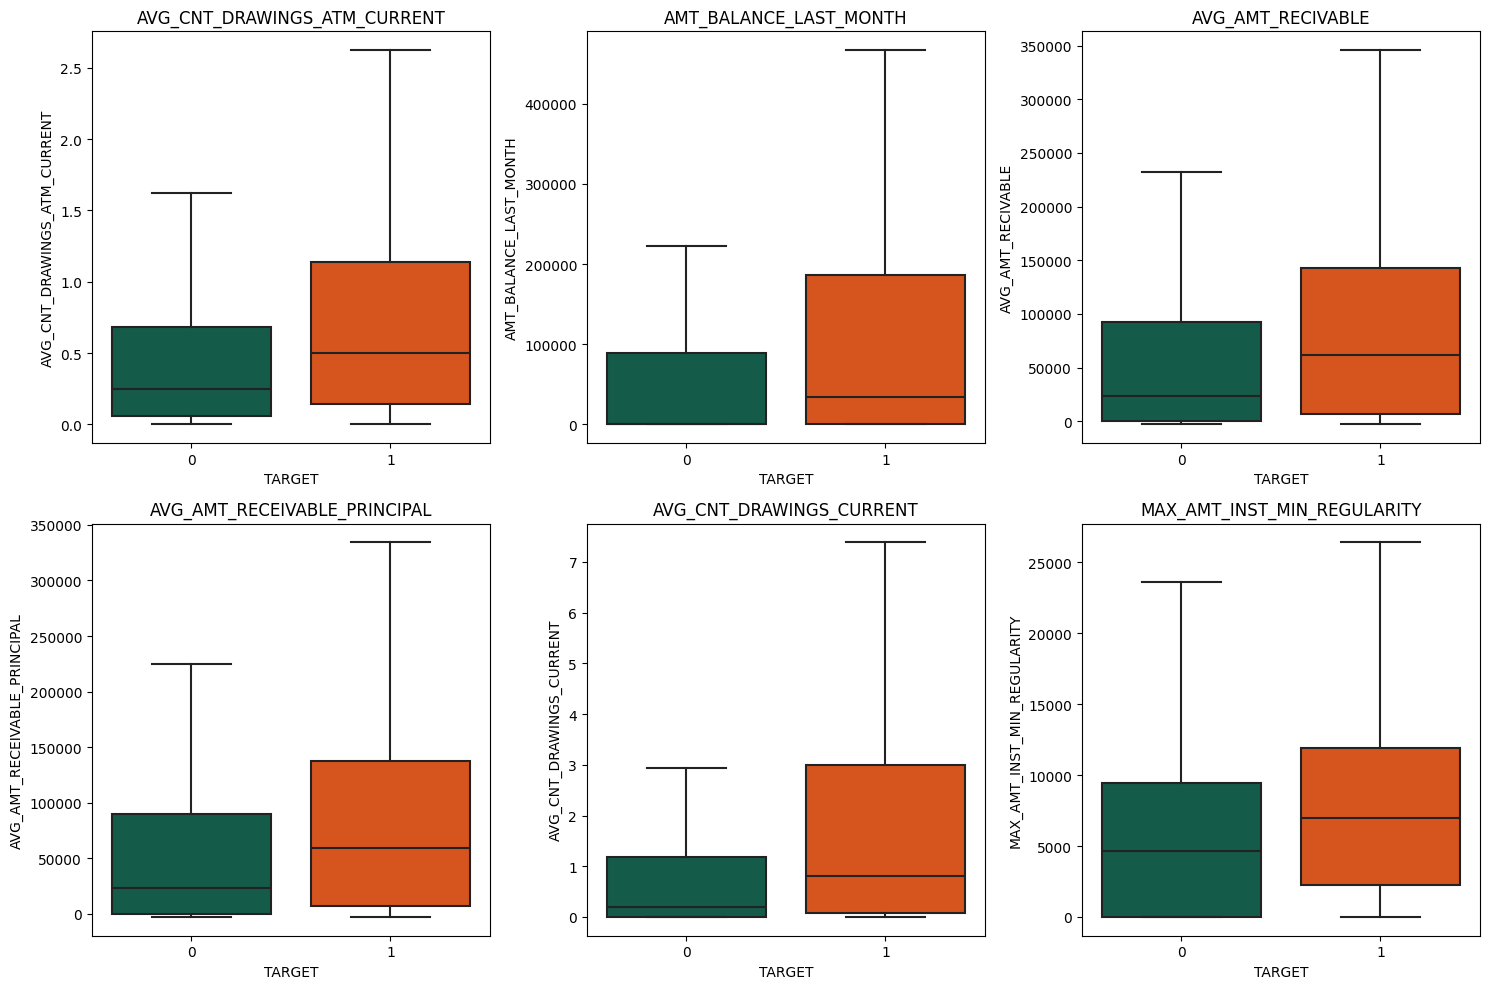

In [78]:
plot_boxplots(new_features, corr_matrix_abs.index[1:7], 'TARGET', pos_color, neg_color)

In [79]:
df_credit_card_balance_features.to_csv('../data/tables/credit_card_balance_features.csv', index=False)

#### 4.2.2 Previous Application
After training the model with the new features we got an improvement, but there's still room for more, so let's continue the work.

In [51]:
df_previous_application = pd.read_csv('../data/tables/previous_application.csv')
print(df_previous_application.shape)
df_previous_application.head()

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
_, categorical_columns = get_column_types(df_previous_application,3)

Numerical columns: 19 ['SK_ID_PREV', 'SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
Categorical columns: 18 ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'NFLAG_INSURED_ON_APPROVAL']


In [5]:
categorical_aggregations = aggregate_categorical(df_previous_application, categorical_columns)
print(categorical_aggregations.shape)
categorical_aggregations.head()

(338857, 147)


,NAME_CONTRACT_TYPE_Cash loans_COUNT,NAME_CONTRACT_TYPE_Consumer loans_COUNT,NAME_CONTRACT_TYPE_Revolving loans_COUNT,NAME_CONTRACT_TYPE_XNA_COUNT,WEEKDAY_APPR_PROCESS_START_FRIDAY_COUNT,WEEKDAY_APPR_PROCESS_START_MONDAY_COUNT,WEEKDAY_APPR_PROCESS_START_SATURDAY_COUNT,WEEKDAY_APPR_PROCESS_START_SUNDAY_COUNT,WEEKDAY_APPR_PROCESS_START_THURSDAY_COUNT,WEEKDAY_APPR_PROCESS_START_TUESDAY_COUNT,...,PRODUCT_COMBINATION_POS household with interest_COUNT,PRODUCT_COMBINATION_POS household without interest_COUNT,PRODUCT_COMBINATION_POS industry with interest_COUNT,PRODUCT_COMBINATION_POS industry without interest_COUNT,PRODUCT_COMBINATION_POS mobile with interest_COUNT,PRODUCT_COMBINATION_POS mobile without interest_COUNT,PRODUCT_COMBINATION_POS other with interest_COUNT,PRODUCT_COMBINATION_POS others without interest_COUNT,NFLAG_INSURED_ON_APPROVAL_0.0_COUNT,NFLAG_INSURED_ON_APPROVAL_1.0_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1.0,0.0
100002,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1.0,0.0
100003,1,2,0,0,1,0,1,1,0,0,...,1,0,1,0,0,0,0,0,1.0,2.0
100004,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1.0,0.0
100005,1,1,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1.0,0.0


In [6]:
aggregations_previous_application = {
    'SK_ID_PREV': [('NUM_APPLOCATIONS', 'count')],
    'AMT_ANNUITY': [('MAX_AMT_ANNUITY', 'max'), ('AVG_AMT_ANNUITY_HC', 'mean')],
    'AMT_APPLICATION': [('MAX_AMT_APPLICATION', 'max'), ('AVG_AMT_APPLICATION', 'mean')],
    'AMT_CREDIT': [('MAX_AMT_CREDIT', 'max'), ('AVG_AMT_CREDIT', 'mean')],
    'AMT_DOWN_PAYMENT': [('MAX_AMT_DOWN_PAYMENT', 'max'), ('AVG_AMT_DOWN_PAYMENT', 'mean')],
    'AMT_GOODS_PRICE': [('MAX_AMT_GOODS_PRICE', 'max'), ('AVG_AMT_GOODS_PRICE', 'mean')],
    'HOUR_APPR_PROCESS_START': [('AVG_HOUR_APPR_PROCESS_START', 'mean')],
    'RATE_DOWN_PAYMENT': [('MAX_RATE_DOWN_PAYMENT', 'max'), ('AVG_RATE_DOWN_PAYMENT', 'mean')],
    'RATE_INTEREST_PRIMARY': [('MAX_RATE_INTEREST_PRIMARY', 'max'), ('AVG_RATE_INTEREST_PRIMARY', 'mean')],
    'RATE_INTEREST_PRIVILEGED': [('MAX_RATE_INTEREST_PRIVILEGED', 'max'), ('AVG_RATE_INTEREST_PRIVILEGED', 'mean')],
    'DAYS_DECISION': [('MAX_DAYS_DECISION', 'max'), ('AVG_DAYS_DECISION', 'mean')],
    'CNT_PAYMENT': [('AVG_CNT_PAYMENT', 'mean')],
    'DAYS_FIRST_DRAWING': [('AVG_DAYS_FIRST_DRAWING', 'mean'), ('MAX_DAYS_FIRST_DRAWING', 'max')],
    'DAYS_FIRST_DUE': [('MAX_DAYS_FIRST_DUE', 'max'), ('MIN_DAYS_FIRST_DUE', 'min')],
    'DAYS_LAST_DUE': [('MAX_DAYS_LAST_DUE', 'max'), ('MIN_DAYS_LAST_DUE', 'min')],
    'DAYS_TERMINATION': [('MAX_DAYS_TERMINATION', 'max'), ('MIN_DAYS_TERMINATION', 'min')]
}

numerical_aggregations = df_previous_application.groupby('SK_ID_CURR').agg(aggregations_previous_application)
numerical_aggregations.columns = numerical_aggregations.columns = [col[1] for col in numerical_aggregations.columns]

print(numerical_aggregations.shape)
numerical_aggregations.head()


(338857, 29)


,NUM_APPLOCATIONS,MAX_AMT_ANNUITY,AVG_AMT_ANNUITY_HC,MAX_AMT_APPLICATION,AVG_AMT_APPLICATION,MAX_AMT_CREDIT,AVG_AMT_CREDIT,MAX_AMT_DOWN_PAYMENT,AVG_AMT_DOWN_PAYMENT,MAX_AMT_GOODS_PRICE,...,AVG_DAYS_DECISION,AVG_CNT_PAYMENT,AVG_DAYS_FIRST_DRAWING,MAX_DAYS_FIRST_DRAWING,MAX_DAYS_FIRST_DUE,MIN_DAYS_FIRST_DUE,MAX_DAYS_LAST_DUE,MIN_DAYS_LAST_DUE,MAX_DAYS_TERMINATION,MIN_DAYS_TERMINATION
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,3951.000,3951.000,24835.5,24835.50,23787.0,23787.00,2520.0,2520.0,24835.5,...,-1740.0,8.0,365243.0,365243.0,-1709.0,-1709.0,-1619.0,-1619.0,-1612.0,-1612.0
100002,1,9251.775,9251.775,179055.0,179055.00,179055.0,179055.00,0.0,0.0,179055.0,...,-606.0,24.0,365243.0,365243.0,-565.0,-565.0,-25.0,-25.0,-17.0,-17.0
100003,3,98356.995,56553.990,900000.0,435436.50,1035882.0,484191.00,6885.0,3442.5,900000.0,...,-1305.0,10.0,365243.0,365243.0,-716.0,-2310.0,-536.0,-1980.0,-527.0,-1976.0
100004,1,5357.250,5357.250,24282.0,24282.00,20106.0,20106.00,4860.0,4860.0,24282.0,...,-815.0,4.0,365243.0,365243.0,-784.0,-784.0,-724.0,-724.0,-714.0,-714.0
100005,2,4813.200,4813.200,44617.5,22308.75,40153.5,20076.75,4464.0,4464.0,44617.5,...,-536.0,12.0,365243.0,365243.0,-706.0,-706.0,-466.0,-466.0,-460.0,-460.0


In [7]:
df_previous_application_features = pd.concat([numerical_aggregations, categorical_aggregations], axis = 1).reset_index()
df_previous_application_features.head()

,SK_ID_CURR,NUM_APPLOCATIONS,MAX_AMT_ANNUITY,AVG_AMT_ANNUITY_HC,MAX_AMT_APPLICATION,AVG_AMT_APPLICATION,MAX_AMT_CREDIT,AVG_AMT_CREDIT,MAX_AMT_DOWN_PAYMENT,AVG_AMT_DOWN_PAYMENT,...,PRODUCT_COMBINATION_POS household with interest_COUNT,PRODUCT_COMBINATION_POS household without interest_COUNT,PRODUCT_COMBINATION_POS industry with interest_COUNT,PRODUCT_COMBINATION_POS industry without interest_COUNT,PRODUCT_COMBINATION_POS mobile with interest_COUNT,PRODUCT_COMBINATION_POS mobile without interest_COUNT,PRODUCT_COMBINATION_POS other with interest_COUNT,PRODUCT_COMBINATION_POS others without interest_COUNT,NFLAG_INSURED_ON_APPROVAL_0.0_COUNT,NFLAG_INSURED_ON_APPROVAL_1.0_COUNT
0,100001,1,3951.000,3951.000,24835.5,24835.50,23787.0,23787.00,2520.0,2520.0,...,0,0,0,0,1,0,0,0,1.0,0.0
1,100002,1,9251.775,9251.775,179055.0,179055.00,179055.0,179055.00,0.0,0.0,...,0,0,0,0,0,0,1,0,1.0,0.0
2,100003,3,98356.995,56553.990,900000.0,435436.50,1035882.0,484191.00,6885.0,3442.5,...,1,0,1,0,0,0,0,0,1.0,2.0
3,100004,1,5357.250,5357.250,24282.0,24282.00,20106.0,20106.00,4860.0,4860.0,...,0,0,0,0,0,1,0,0,1.0,0.0
4,100005,2,4813.200,4813.200,44617.5,22308.75,40153.5,20076.75,4464.0,4464.0,...,0,0,0,0,1,0,0,0,1.0,0.0


In [8]:
df_previous_application_features.to_csv('../data/tables/previous_application_features.csv', index=False)

### 4.2.3 POS_CASH balance

In [52]:
df_POS_CASH_balance = pd.read_csv('../data/tables/POS_CASH_balance.csv')
print(df_POS_CASH_balance.shape)
df_POS_CASH_balance.head()

(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [65]:
aggregations = {
    'CNT_INSTALMENT': [
        ('AVG_CNT_INSTALMENT', 'mean'),
        ('MAX_CNT_INSTALMENT', 'max')
    ],
    'CNT_INSTALMENT_FUTURE': [
        ('AVG_CNT_INSTALMENT_FUTURE', 'mean'),
        ('MAX_CNT_INSTALMENT_FUTURE', 'max')
    ],
    'SK_DPD': [
        ('MAX_SK_DPD', 'max'),
        ('AVG_SK_DPD', 'mean')
    ],
    'SK_DPD_DEF': [
        ('MAX_SK_DPD_DEF', 'max'),
        ('AVG_SK_DPD_DEF', 'mean')
    ]
}

features_POS_CASH_balance = df_POS_CASH_balance.groupby('SK_ID_CURR').agg(aggregations)
features_POS_CASH_balance.columns = [col[1] for col in features_POS_CASH_balance.columns]
features_POS_CASH_balance

print(features_POS_CASH_balance.shape)
features_POS_CASH_balance.head()


(337252, 8)


,AVG_CNT_INSTALMENT,MAX_CNT_INSTALMENT,AVG_CNT_INSTALMENT_FUTURE,MAX_CNT_INSTALMENT_FUTURE,MAX_SK_DPD,AVG_SK_DPD,MAX_SK_DPD_DEF,AVG_SK_DPD_DEF
SK_ID_CURR,,,,,,,,
100001,4.000000,4.0,1.444444,4.0,7,0.777778,7,0.777778
100002,24.000000,24.0,15.000000,24.0,0,0.000000,0,0.000000
100003,10.107143,12.0,5.785714,12.0,0,0.000000,0,0.000000
100004,3.750000,4.0,2.250000,4.0,0,0.000000,0,0.000000
100005,11.700000,12.0,7.200000,12.0,0,0.000000,0,0.000000


In [67]:
max_index = df_POS_CASH_balance.groupby('SK_ID_CURR')['MONTHS_BALANCE'].idxmax()

last_month_max_values = df_POS_CASH_balance.loc[max_index,['SK_ID_CURR',
                                                           'CNT_INSTALMENT', 
                                                           'CNT_INSTALMENT_FUTURE', 
                                                           'SK_DPD', 'SK_DPD_DEF']]\
                                                            .set_index('SK_ID_CURR')

last_month_max_values.rename(columns={'CNT_INSTALMENT':'CNT_INSTALMENT_LAST_MONTH', 
                                      'CNT_INSTALMENT_FUTURE': 'CNT_INSTALMENT_FUTURE_LAST_MONTH', 
                                      'SK_DPD': 'SK_DPD_LAST_MONTH',
                                      'SK_DPD_DEF': 'SK_DPD_DEF_LAST_MONTH' }, 
                                      inplace=True)
print(last_month_max_values.shape)
last_month_max_values.head()

(337252, 4)


,CNT_INSTALMENT_LAST_MONTH,CNT_INSTALMENT_FUTURE_LAST_MONTH,SK_DPD_LAST_MONTH,SK_DPD_DEF_LAST_MONTH
SK_ID_CURR,,,,
100001,4.0,0.0,0,0
100002,24.0,6.0,0,0
100003,7.0,0.0,0,0
100004,3.0,0.0,0,0
100005,9.0,0.0,0,0


In [69]:
df_POS_CASH_balance_features = pd.concat([features_POS_CASH_balance, last_month_max_values], axis = 1)
df_POS_CASH_balance_features.to_csv('../data/tables/POS_CASH_balance_features.csv')

### 4.2.4 Installments Payments

In [2]:
df_installments_payments = pd.read_csv('../data/tables/installments_payments.csv')
print(df_installments_payments.shape)
df_installments_payments.head()

(13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [5]:
aggregations = {
    'NUM_INSTALMENT_VERSION': [
        ('AVG_NUM_INSTALMENT_VERSION', 'mean'),
        ('MAX_NUM_INSTALMENT_VERSION', 'max')
    ],
    'NUM_INSTALMENT_NUMBER': [
        ('AVG_NUM_INSTALMENT_NUMBER', 'mean'),
        ('MAX_NUM_INSTALMENT_NUMBER', 'max')
    ],
    'DAYS_INSTALMENT': [
        ('AVG_DAYS_INSTALMENT', 'mean'),
        ('MAX_DAYS_INSTALMENT', 'max')
    ],
    'DAYS_ENTRY_PAYMENT': [
        ('AVG_DAYS_ENTRY_PAYMENT', 'mean'),
        ('MAX_DAYS_ENTRY_PAYMENT', 'max')
    ],
    'AMT_INSTALMENT': [
        ('AVG_AMT_INSTALMENT', 'mean'),
        ('MAX_AMT_INSTALMENT', 'max')
    ],
    'AMT_PAYMENT': [
        ('AVG_AMT_PAYMENT', 'mean'),
        ('MAX_AMT_PAYMENT', 'max')
    ]
}

features_installments_payments = df_installments_payments.groupby('SK_ID_CURR').agg(aggregations)

features_installments_payments.columns = [col[1] for col in features_installments_payments.columns]

print(features_installments_payments.shape)
features_installments_payments.head()

(339587, 12)


,AVG_NUM_INSTALMENT_VERSION,MAX_NUM_INSTALMENT_VERSION,AVG_NUM_INSTALMENT_NUMBER,MAX_NUM_INSTALMENT_NUMBER,AVG_DAYS_INSTALMENT,MAX_DAYS_INSTALMENT,AVG_DAYS_ENTRY_PAYMENT,MAX_DAYS_ENTRY_PAYMENT,AVG_AMT_INSTALMENT,MAX_AMT_INSTALMENT,AVG_AMT_PAYMENT,MAX_AMT_PAYMENT
SK_ID_CURR,,,,,,,,,,,,
100001,1.142857,2.0,2.714286,4,-2187.714286,-1619.0,-2195.000000,-1628.0,5885.132143,17397.900,5885.132143,17397.900
100002,1.052632,2.0,10.000000,19,-295.000000,-25.0,-315.421053,-49.0,11559.247105,53093.745,11559.247105,53093.745
100003,1.040000,2.0,5.080000,12,-1378.160000,-536.0,-1385.320000,-544.0,64754.586000,560835.360,64754.586000,560835.360
100004,1.333333,2.0,2.000000,3,-754.000000,-724.0,-761.666667,-727.0,7096.155000,10573.965,7096.155000,10573.965
100005,1.111111,2.0,5.000000,9,-586.000000,-466.0,-609.555556,-470.0,6240.205000,17656.245,6240.205000,17656.245


In [8]:
features_installments_payments.to_csv('../data/tables/installments_payments_features.csv')